## Project Voyage: Final Submission
## Pedal to the (Predicted) Medal

#### Emma Carney, Shiv Chandra, Mads Groeholdt, Max Miller, Bridget Sands
#### December 15th, 2023

## Table of Contents

- [Motivation, Context, & Framing](#motivation-context-framing)
- [Exploratory Data Analysis](#explore-and-visualize-data)
- [Building the Rider History Features](#building-the-rider-history-features)
- [Model Fitting](#model-fitting)
  - [Linear Regression](#linear-regression)
  - [Polynomial Regression](#polynomial-regression)
  - [Decision Tree Prediction](#decision-tree-prediction)
  - [Bagging Prediction](#bagging-prediction)
- [209 Component Blending](#209-component-blending)

<a name="motivation-context-framing"></a>
<a name="exploratory-data-analysis"></a>
<a name="building-the-rider-history-features"></a>
<a name="model-fitting"></a>
<a name="linear-regression"></a>
<a name="polynomial-regression"></a>
<a name="decision-tree-prediction"></a>
<a name="bagging-prediction"></a>
<a name="209-component-blending"></a>

## Problem Statement:
We are trying to use historical rider and course data to predict the results of professional cycling races. We intend to do this without using rider name as a feature (which would just make a mini model for each rider), but create a blind model by engineering features that are unique to each rider and describe a rider's historical success on specific course characteristics. Our baseline goal is to beat a random guess of rider placement.

### Motivation, Context and Framing
There is an increased excitement with the usage of data analytics in professional sports and betting around the world. As we were brainstorming a project revolving around sports, we thought about doing a project in baseball, hockey, football and more. But we really wanted to try something outside of the major U.S. sports which already have lots of attention. That's how we decided on professional cycling!

Everyone knows about the Tour De France, but the Union Cycliste Internationale (UCI) calendar consists of around 35 races of different formats, durations, and importance every year. Every year there is the UCI Road Cycling World Championships at the end of the season and we want to see how well we can predict the order of the finishers. This model could then be used to understand which factors are the most important in cycling, for both fans and professionals. It could also, theoretically, be used for bettors to try to gain an edge or even for sportsbooks to set betting lines.

In cycling, the course metric plays a large role in the results for each athlete, so we thought in addition to looking at historical rider data, we will also take factors like the course’s altitude, incline, distance, weather, etc. into account. We intend to do this without using rider name as a feature (which would just make a mini model for each rider), but create a blind model by engineering features that are unique to each rider and describe a rider's historical success on specific course characteristics. Our baseline goal is to beat a random guess of rider placement.

The next step is to identify the specific predictors we intend to use from our data, and begin the modeling process.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import math
import random
import matplotlib.pyplot as plt
import requests
import urllib3
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter

## 2) Explore and Visualize Data:

As described in Milestone 2 and Milstone 3, we are pulling data from the procyclingstats.com and Strava APIs. Also as described, we are pulling two separate datasets, one containing rider data and one containing course data. 

The course data is stored in `stages`. Each row corresponds to one course / stage, and the columns contain information about the distance, elevation, and other characteristics of the profile of the course. The rider data is stored in `results`. Each row corresponds to an individual rider’s performance in a singular race, and contains general information about that rider. By merging these two data frames on the common race column,  we can create a single consolidated data frame where each row pertains to an individual rider’s performance in a single race, complete with that rider’s background and that course’s profile. See below for more specification about the individual data sets, included variables, and merging.

In [2]:
# read in data frames
stages = pd.read_csv('stages_for_analysis.csv')
results = pd.read_csv('results_for_analysis.csv')

/var/folders/1h/c3gfpphn4f51_4009flfcdwc0000gn/T/ipykernel_94045/4148118541.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv('results_for_analysis.csv')


#### First, let's dive into our "stages" dataframe:

The stages dataframe starts with the following features/columns:
- race (dtype: string): specifies race by year and racing championship → like key/categorical indicator // Ex: 'race/world-championship/2018', 'race/world-championship/2019'
- race_name (dtype: string): specifies race by championship name // Ex: 'World Championships ME - Road Race', 'Amstel Gold Race'
- stage_number (dtype: int): specifies stage number of race, if applicable
- stage (dtype: string): specifies race by stage, year and racing championship → like key/categorical indicator, similar to “race” // Ex: 'race/tour-de-france/2018/stage-1', 'race/tour-de-france/2018/stage-2',
- stage_date (dtype: date): date of the specific stage
- distance (dtype: float): distance of stage in meters
- elev_gain (dtype: float): elevation gain in a stage in meters
- climb_urls (dtype: list[string]): list that contains climb names (if any) of that stage
- startlist_quality (dtype: int): metric created by procyclingstats, “to put a numeric value to the quality of the riders at the start of a race, we have devised the PCS startlist quality scale. With this scale it is possible to compare races within a season, but also with historical races.”; it essentially  quantifies how the quality of riders at the start of the stage; more specific information here
- profile_score (dtype: float): metric created by procycling stats, “the 'PCS ProfileScore' is mainly developed to assign points to riders for their climbing capabilities.”; it is essentially to quantify how steep/hard a stage is;  more information here
- finish_type (dtype: string): describes the type of finish for the stage


In [3]:
# Understand Stage data
print(stages.columns)
print(stages.dtypes)
stages.head()

Index(['race', 'race_name', 'stage_number', 'stage', 'stage_date', 'distance',
       'elev_gain', 'climb_urls', 'startlist_quality', 'profile_score',
       'finish_type'],
      dtype='object')
race                  object
race_name             object
stage_number         float64
stage                 object
stage_date            object
distance             float64
elev_gain            float64
climb_urls            object
startlist_quality      int64
profile_score        float64
finish_type           object
dtype: object


,race,race_name,stage_number,stage,stage_date,distance,elev_gain,climb_urls,startlist_quality,profile_score,finish_type
0,race/world-championship/2018,World Championships ME - Road Race,NaN,NaN,2018-09-30,258.0,5020.0,[],1374,265.0,Sprint of small group
1,race/world-championship/2019,World Championships ME - Road Race,NaN,NaN,2019-09-29,260.7,3220.0,[],1443,82.0,Sprint of small group
2,race/world-championship/2020,World Championships ME - Road Race,NaN,NaN,2020-09-27,258.2,4662.0,[],1008,208.0,12 km solo
3,race/world-championship/2021,World Championships ME - Road Race,NaN,NaN,2021-09-26,268.3,2250.0,[],1357,54.0,17.4 km solo
4,race/world-championship/2022,World Championships ME - Road Race,NaN,NaN,2022-09-25,266.9,4167.0,[],1052,160.0,25.8 km solo


#### Need to make sure race_date is datetime object:
All of the other variables and their respective types look good, however.

In [4]:
from datetime import datetime

# format of date string
date_format = "%Y-%m-%d"

# Convert the string to a datetime object
stages['stage_date'] = [datetime.strptime(x, date_format) for x in stages['stage_date']]

In [5]:
stages.dtypes

race                         object
race_name                    object
stage_number                float64
stage                        object
stage_date           datetime64[ns]
distance                    float64
elev_gain                   float64
climb_urls                   object
startlist_quality             int64
profile_score               float64
finish_type                  object
dtype: object

#### Check and handle NAs:

In [6]:
stages.isna().sum()

race                  0
race_name             0
stage_number         57
stage                57
stage_date            0
distance              0
elev_gain             1
climb_urls            0
startlist_quality     0
profile_score         1
finish_type           0
dtype: int64

In [7]:
stages[stages['elev_gain'].isna()]

,race,race_name,stage_number,stage,stage_date,distance,elev_gain,climb_urls,startlist_quality,profile_score,finish_type
208,race/giro-d-italia/2020,Giro d'Italia,5.0,race/giro-d-italia/2020/stage-5,2020-10-07,225.0,NaN,[],765,NaN,17 km solo


In [8]:
# Missing data manually filled
# Course information from https://www.procyclingstats.com/race/giro-d-italia/2020/gc
stages.at[208, 'elev_gain'] = 3
stages.at[208, 'profile_score'] = 0

In [9]:
stages.isna().sum()

race                  0
race_name             0
stage_number         57
stage                57
stage_date            0
distance              0
elev_gain             0
climb_urls            0
startlist_quality     0
profile_score         0
finish_type           0
dtype: int64

In [10]:
stages[stages['stage'].isna()].head()

,race,race_name,stage_number,stage,stage_date,distance,elev_gain,climb_urls,startlist_quality,profile_score,finish_type
0,race/world-championship/2018,World Championships ME - Road Race,NaN,NaN,2018-09-30,258.0,5020.0,[],1374,265.0,Sprint of small group
1,race/world-championship/2019,World Championships ME - Road Race,NaN,NaN,2019-09-29,260.7,3220.0,[],1443,82.0,Sprint of small group
2,race/world-championship/2020,World Championships ME - Road Race,NaN,NaN,2020-09-27,258.2,4662.0,[],1008,208.0,12 km solo
3,race/world-championship/2021,World Championships ME - Road Race,NaN,NaN,2021-09-26,268.3,2250.0,[],1357,54.0,17.4 km solo
4,race/world-championship/2022,World Championships ME - Road Race,NaN,NaN,2022-09-25,266.9,4167.0,[],1052,160.0,25.8 km solo


#### Sometimes in professional cycling, there are races that are multi-stage races, while others are just the singular race.
Therefore, in our data, there are some races with missing "stage" names, since those are single-day races and thereby do not have "stages" within them. It makes more sense to consider each stage its own individual race rather than each multi-layer stage race a singular race because of the variety of stage characteristics. Therefore we proceed with consolidating the empty "stage" rows with the single-day races:

#### Clear that the rows with missing stages are just races with one single stage, transfer the name over:
By doing such we handle all 57 indicated NAs in the dataset.

In [11]:
stages['stage'] = stages['stage'].fillna(stages['race'])

In [12]:
stages.isna().sum()

race                  0
race_name             0
stage_number         57
stage                 0
stage_date            0
distance              0
elev_gain             0
climb_urls            0
startlist_quality     0
profile_score         0
finish_type           0
dtype: int64

#### Let's look into the relationships between the metrics that capture course profiles (that don't change relative to the results of each race):

We can see that features such as elevation and distance seem to be positively correlated, which makes sense intuitively. Additionally, we can see that the procyclingstats variable "profile_score" is positively correlated with elevation gain, which makes sense as its definition is a function of, among other things, elevation gain.

The sample of courses seems to have a relatively normally distributed distance. The courses' elevation gains resemble an almost uniform distribution, although they have some Gaussian tendencies, and the profile_score can be seen to be heavily right-skewed.

/Users/bridgetsands/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


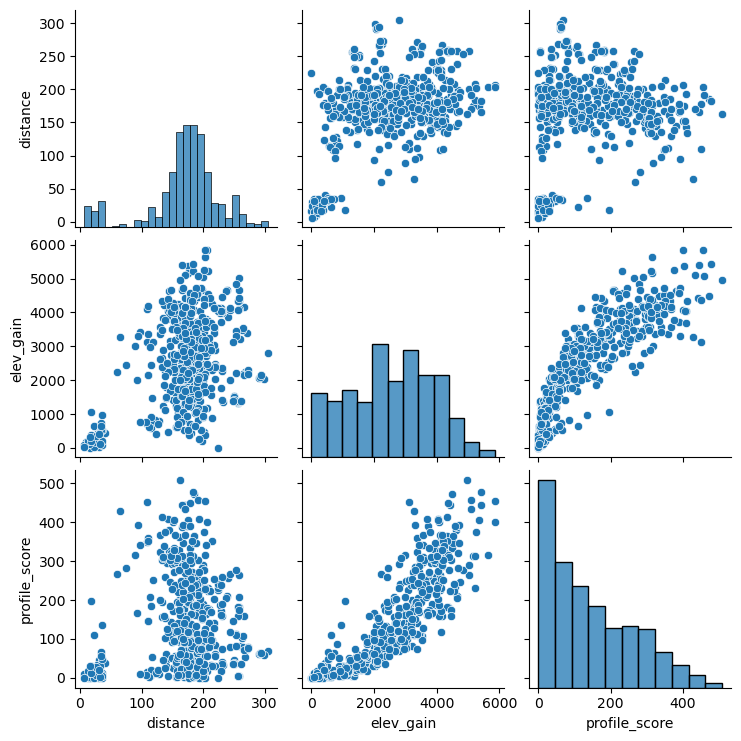

In [13]:
sns.pairplot(stages[['distance', 'elev_gain', 'profile_score']])

#### Next, let's try PCA with these metrics, to see if one of the principal parts can be used instead of all three features:

As mentioned above, there are distinct relationships between the features, most notably between elevation gain and profile score. Therefore, we continue with PCA analysis on all three of the features to see if it is possible to reduce dimensionality.

Number of Components:  3
Explained Variance:  [2.00567435 0.92339885 0.07691483]
Explained Variance Ratio: [0.66722633 0.30718647 0.0255872 ]
Components:  [[ 0.3674407   0.6915112   0.62193215]
 [-0.88612509  0.05722558  0.45989952]
 [ 0.28243524 -0.72009548  0.63379242]]


Text(0.5, 1.0, 'PCA Analysis Relative to Distance and Profile Score')

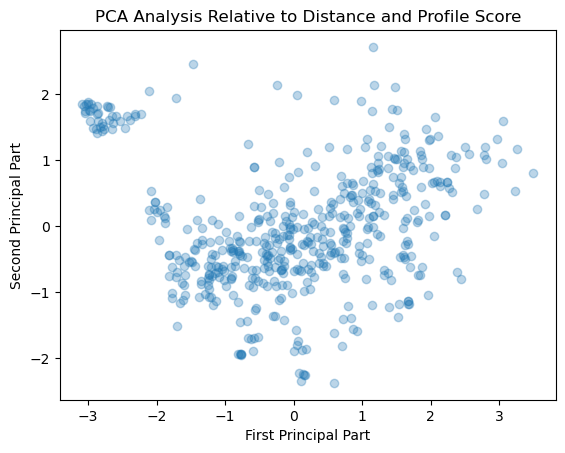

In [14]:
# PCA
# imports 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Identify metrics that can be used in PCA analysis as feature in 'results'
# Metrics that don't change

stages_pca = stages[['distance', 'elev_gain', 'profile_score']]
stages_pca.head()

X_std = StandardScaler().fit_transform(stages_pca)
pca = PCA().fit(X_std)

X_pca = pca.transform(X_std)

print("Number of Components: ", pca.n_components_)
print("Explained Variance: ", pca.explained_variance_)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Components: ", pca.components_)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha =.3)
plt.xlabel("First Principal Part")
plt.ylabel("Second Principal Part")
plt.title("PCA Analysis Relative to Distance and Profile Score")

#### PCA shows us that there is no significant relationship between the two principal parts, therefore it makes sense to proceed without using the principal components but rather with the features themselves. What we can do is use only one of the features of [elev_gain, profile_score], as proven by the sns pairplot, they are quite related. We believe that we should proceed with profile_score, as it is a procyclingstats-engineered feature in order to understand course difficulty relative to elevation any a few additional features. Higher elevations lead to higher profile scores, so it would be redundant to include both.

#### Now that we have dug into the "stage" dataframe that houses the course data, we can do the same with the "results" dataframe that houses the rider data:
The "results" dataframe starts with the following columns/features:
- race (dtype: string): same as “race” column in all_stages: specifies race by year and racing championship → like key/categorical indicator // Ex: 'race/world-championship/2018', 'race/world-championship/2019'
- stage (dtype: string): same as “rstage” column in all_stages: name of the stage: specifies race by stage, year and racing championship → like key/categorical indicator, similar to “race” // Ex: 'race/tour-de-france/2018/stage-1', 'race/tour-de-france/2018/stage-2',
- stage_rank (dtype: int): rider’s rank/place in the stage
- specialty (dtype: string):  rider’s specialty we 
- rider_name (dtype: string): rider’s name
- rider_age (mean: 28.43, max: 42, dtype: int): rider’s age
- rider_team (dtype: string): name of rider’s team
- UCI_points (dtype: int): point system which is used to rank men’s road cycling riders
- points (dtype: int): total points for a rider (first rider gets 5 points, second rider gets 2, third rider gets 2, fourth rider gets 1, and points in the last sprint are doubled, see here for more)
- time (dtype: int): time for completing each race


In [15]:
results.dtypes

race           object
stage          object
stage_rank     object
specialty      object
rider_name     object
rider_age       int64
rider_team     object
UCI_points    float64
points        float64
time           object
dtype: object

In [16]:
# Evaluate nas
results.isna().sum()

race              0
stage          9911
stage_rank        0
specialty         0
rider_name        0
rider_age         0
rider_team        0
UCI_points    73945
points        67500
time          67430
dtype: int64

#### The first thing that is obvious is that there are an abundance of NAs. Let's first consider the stage NAs in the same way we did in the "stages" dataset.

In [17]:
results[results['stage'].isna()].head()

,race,stage,stage_rank,specialty,rider_name,rider_age,rider_team,UCI_points,points,time
69923,race/world-championship/2018,NaN,1,Climber,VALVERDE Alejandro,38,Spain,600.0,350.0,6:46:41
69924,race/world-championship/2018,NaN,2,Climber,BARDET Romain,27,France,475.0,260.0,0:00
69925,race/world-championship/2018,NaN,3,Climber,WOODS Michael,31,Canada,400.0,190.0,0:00
69926,race/world-championship/2018,NaN,4,TT,DUMOULIN Tom,27,Netherlands,325.0,150.0,0:00
69927,race/world-championship/2018,NaN,5,Classic,MOSCON Gianni,24,Italy,275.0,130.0,0:130:13


In [18]:
results['stage'] = results['stage'].fillna(results['race'])

#### Another thing that we see is that stage_rank's default datatype is an object. We need to change the stage_rank data type to be numerical to work for our intended predictive models - lets first understand where it might have gone wrong:

In [19]:
results['stage_rank'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '\xa099\xa0',
       '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '110', '111', '112', '113', '114', '115', '116', '117',
       '118', '119', '120', '121', '122', '123', '124', '125', '126',
       '127', '128', '129', '130', '131', '132', '133', '134', '135',
       '136', '137', '138', '139', '140', '141', '142', '143', '

#### It is apparant that there were some issues with saving the variable values when scraping. We can move forward with fixing this next:
The strings making the variable into an object are descriptive ones related to 
- DNF: Did Not Finish
- DNS: Did Not Start
- OTL: Outside Time Limit
- DSQ: Disqualified
These are all explanations for why the numerical rank of a rider is not observed. An option for dealing with these are making additional predictors as binary variables for each of the options, but for our initial approach we will choose to omit these observations and strictly work with the numerical options.

In [20]:
def help1(st):
    if st.strip() in ['DNF', 'DF', 'DNS', 'OTL', 'DSQ']:
        return 
    elif st.isnumeric():
        return int(st)
    else:
        return int(st.split("\xa0")[1])

In [21]:
results['stage_rank'] = [help1(x) for x in results['stage_rank']]

In [22]:
results.dtypes

race           object
stage          object
stage_rank    float64
specialty      object
rider_name     object
rider_age       int64
rider_team     object
UCI_points    float64
points        float64
time           object
dtype: object

### Deciding on a Response Variable
Considering the competitive format of cycling, using competition time or UCI points received as the response variable is a natural initial exploration.

#### To confirm we are able to use either as a response variable, let's explore said feature columns.

In [23]:
print("The total amount of results we are considering are: ", len(results))
results[['time', 'points']].isna().sum()

The total amount of results we are considering are:  79834


time      67430
points    67500
dtype: int64

#### This indicates, unfortunately, that of the 79,834 results in our dataset, that 67,430 have missing time values, and 67,500 have missing points values. Before we rule it out completely, let us explore the dataset where they are NAs: 

In [24]:
display(results[results['time'].isna()])
display(results[results['time'].isna()].describe())

display(results[results['points'].isna()])
display(results[results['points'].isna()].describe())

,race,stage,stage_rank,specialty,rider_name,rider_age,rider_team,UCI_points,points,time
5,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,6.0,Sprint,GROENEWEGEN Dylan,25,Team LottoNL-Jumbo,NaN,26.0,NaN
6,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,7.0,Climber,MATTHEWS Michael,27,Team Sunweb,NaN,22.0,NaN
7,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,8.0,Classic,DEGENKOLB John,29,Trek - Segafredo,NaN,18.0,NaN
8,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,9.0,Climber,FUGLSANG Jakob,33,Astana Pro Team,NaN,14.0,NaN
9,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,10.0,Climber,MAJKA Rafał,28,BORA - hansgrohe,NaN,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...
69918,race/dauphine/2023,race/dauphine/2023/stage-8,NaN,TT,THOMAS Benjamin,27,Cofidis,NaN,NaN,NaN
69919,race/dauphine/2023,race/dauphine/2023/stage-8,NaN,Classic,URIANSTAD BUGGE Martin,24,Uno-X Pro Cycling Team,NaN,NaN,NaN
69920,race/dauphine/2023,race/dauphine/2023/stage-8,NaN,Climber,DE GENDT Thomas,36,Lotto Dstny,NaN,NaN,NaN
69921,race/dauphine/2023,race/dauphine/2023/stage-8,NaN,Climber,LATOUR Pierre,29,TotalEnergies,NaN,NaN,NaN


,stage_rank,rider_age,UCI_points,points
count,65959.000000,67430.000000,0.0,3524.000000
mean,82.441032,28.519413,NaN,7.736947
std,45.105531,4.311273,NaN,6.093909
min,2.000000,18.000000,NaN,1.000000
25%,44.000000,25.000000,NaN,3.000000
50%,81.000000,28.000000,NaN,6.000000
75%,120.000000,32.000000,NaN,10.000000
max,184.000000,42.000000,NaN,26.000000


,race,stage,stage_rank,specialty,rider_name,rider_age,rider_team,UCI_points,points,time
15,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,16.0,Classic,VALGREN Michael,26,Astana Pro Team,NaN,NaN,NaN
16,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,17.0,Sprint,RICHEZE Maximiliano,35,Quick-Step Floors,NaN,NaN,NaN
17,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,18.0,Classic,GILBERT Philippe,36,Quick-Step Floors,NaN,NaN,NaN
18,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,19.0,Sprint,BOASSON HAGEN Edvald,31,Team Dimension Data,NaN,NaN,NaN
19,race/tour-de-france/2018,race/tour-de-france/2018/stage-1,20.0,Classic,COLBRELLI Sonny,28,Bahrain Merida Pro Cycling Team,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
79829,race/san-sebastian/2023,race/san-sebastian/2023,NaN,TT,AZPARREN Xabier Mikel,24,Euskaltel - Euskadi,NaN,NaN,-
79830,race/san-sebastian/2023,race/san-sebastian/2023,NaN,Climber,ISASA Xabier,21,Euskaltel - Euskadi,NaN,NaN,-
79831,race/san-sebastian/2023,race/san-sebastian/2023,NaN,TT,ELOSEGUI Iñigo,25,Equipo Kern Pharma,NaN,NaN,-
79832,race/san-sebastian/2023,race/san-sebastian/2023,NaN,TT,CABOT Jérémy,32,TotalEnergies,NaN,NaN,-


,stage_rank,rider_age,UCI_points,points
count,62436.000000,67500.000000,1.0,0.0
mean,86.538023,28.502222,8.0,NaN
std,42.831373,4.342055,NaN,NaN
min,2.000000,18.000000,8.0,NaN
25%,50.000000,25.000000,8.0,NaN
50%,86.000000,28.000000,8.0,NaN
75%,122.000000,32.000000,8.0,NaN
max,184.000000,42.000000,8.0,NaN


#### Missingness Category
As the missing values represent over 84% of the data for both columns, it would not only be a strong assumption to assume that the missing values are MCAR, but it would also be irresponsible to impute from such a small portion of the data set as it would be highly unlikely that the synthezized data would be unbiased, especially because different racers perform better or worse relative to the type of race/race characteristics as described further below. **Therefore, it is infeasible to use the column "time" or "points" as the response variable.**

Additionally, for some qualitative context, anyone familiar with road cycling will know that it is a sport that is heavily heterogeneous when it comes to racing tactics and speed throughout a race, which means that two races on the same course with the same riders, but on different days, likely will have substantially different finishing times. This is an additional reason why "time" likely would be a poor predictor, as it depends on the competitors' intentions on a given day rather than the individual riders' capabilities.

Rather than time or UCI points, we will therefore choose a variable which has 0 missing observations in the data: stage rank (or rider race places; ie first, second, third, etc). This means that for each rider on the startlist of a given course, we will attempt to predict their end-result (**see below for specific design of response variable**) based on their empirical performance and features of the course.

### Now, we move forward and put all data for our project together: combining the "stages" and "results" dataframes in order to create a consolidated dataframe on which we can train models.

We are combining the data so that each data point in the dataframe has rider information as well as course information. Each row in the final dataframe represents a rider's specifics, the course/race specifics, and their result. 

We first build and merge the initial combined dataframe, and later fine tune it for modeling.

Note that at this point in the EDA it does not make sense to create visualizations for the `results` dataframe, as our model intends to predict without rider name as a feature (instead we will incorporate historical performance on a rider-by-rider basis using a original method, explained later). Therefore, the visualizations will be both more intuitive and helpful after we engineer features to incorporate rider history.

In [25]:
results.columns

Index(['race', 'stage', 'stage_rank', 'specialty', 'rider_name', 'rider_age',
       'rider_team', 'UCI_points', 'points', 'time'],
      dtype='object')

#### What Features to Keep (and Discard) from `results` Dataframe

##### Useful in Model Building:
- stage as distinct indicator to link course specific data

- stage_rank necessary as part of final predictor

- rider_name for linking later to model results

- rider_age as quantitative feature

- specialty as qualitiative feature, one-hot encoding to come

##### Unnecessary for Future Work:
- race, as the stage column covers what we need

- rider_team, because we are end-goal predicting how cyclists do independently rather than with their team, we are assuming team independence, and can ignore/drop rider_team. Also many NAs in that column.

- time, as we proved above, inconsistent data

- UCI_points, as we proved above, inconsitent data 


In [26]:
# prep columns for linking
temp1 = results[['stage', 'stage_rank', 'specialty', 'rider_name', 'rider_age']].copy()
temp1.head()

,stage,stage_rank,specialty,rider_name,rider_age
0,race/tour-de-france/2018/stage-1,1.0,Sprint,GAVIRIA Fernando,23
1,race/tour-de-france/2018/stage-1,2.0,Sprint,SAGAN Peter,28
2,race/tour-de-france/2018/stage-1,3.0,Sprint,KITTEL Marcel,30
3,race/tour-de-france/2018/stage-1,4.0,Classic,KRISTOFF Alexander,31
4,race/tour-de-france/2018/stage-1,5.0,Classic,LAPORTE Christophe,25


In [27]:
# time to link
stages.columns

Index(['race', 'race_name', 'stage_number', 'stage', 'stage_date', 'distance',
       'elev_gain', 'climb_urls', 'startlist_quality', 'profile_score',
       'finish_type'],
      dtype='object')

#### What Features to Keep (and Discard) from `stages` dataframe

##### Useful in Model Building:
- stage as distinct indicator to link with "results"

- stage_date, necessary for model fitting/ensure no data leakage

- distance, quantitative race characteristic feature

- elev_gain, quantitative race characteristic feature

- startlist_quality, quantitative race characteristic, different for each race (explains the quality of other racers in the race)

- profile_score, quantitative race characteristic feature, proven by PCA to be necessary to consider independently

##### Unnecessary for Future Work:
- race, race_name, stage_number: the stage column covers what we need

- climb_urls: irrelevant, inconsistent

- finish_type: dependent on finish of each race, we can't use, as it creates data leakage as we don't know the type of race finish before the race actually finishes

In [28]:
# prep stages for merge
temp2 = stages[['stage', 'stage_date', 'distance', 'elev_gain', 'startlist_quality', 'profile_score']].copy()

In [29]:
# merge
df = pd.merge(temp1, temp2, on='stage', how='left')

In [30]:
# inspect
df.head()

,stage,stage_rank,specialty,rider_name,rider_age,stage_date,distance,elev_gain,startlist_quality,profile_score
0,race/tour-de-france/2018/stage-1,1.0,Sprint,GAVIRIA Fernando,23,2018-07-07,201.0,454.0,1689,2.0
1,race/tour-de-france/2018/stage-1,2.0,Sprint,SAGAN Peter,28,2018-07-07,201.0,454.0,1689,2.0
2,race/tour-de-france/2018/stage-1,3.0,Sprint,KITTEL Marcel,30,2018-07-07,201.0,454.0,1689,2.0
3,race/tour-de-france/2018/stage-1,4.0,Classic,KRISTOFF Alexander,31,2018-07-07,201.0,454.0,1689,2.0
4,race/tour-de-france/2018/stage-1,5.0,Classic,LAPORTE Christophe,25,2018-07-07,201.0,454.0,1689,2.0


In [31]:
df.columns = ['race', 'race_place', 'rider_specialty', 'rider_name', 'rider_age', 'race_date', 'race_dist', 'race_elev_gain', 'race_startlist_qual','race_profile_score']

Now `df` is a single, conslidated dataframe that combines the relevant information from `results` and `stages`.

### Response Variable

Although our end prediction will be the riders' ranks in each race, `race_place` is an integer value, which makes it more intricate to predict than a continuous one. Additionally, it is required to be unique for each rider, which makes the prediction process more challenging as well. Lastly, the rank of any given race is not as comparable between races because different races have different numbers of competitors on their startlist. Therefore, we are going use 'race_startlist_qual' divided by 'race_place' as the response variable.

As described in our Milestone 3, 'race_startlist_qual' is a metric that is engineered by procyclingstats that describes the competitiveness of the field for a race. A race that has a higher 'race_startlist_qual' is harder to win, while one with a lower has less impressive racers participating.

Therefore, by dividing 'race_startlist_qual' by 'race_place', we standardize the response variable to reflect the competitiveness of each race, and as a result our model will assign more weight to harder races.

By engineering our own response variable in this way, we prevent the issue of predicting `race_place`, an integer required to be unique to each rider in a race. Instead, we predict our continuous response variable, and then dependent on the order of the predictions, assign the predicted race place sequentially as the racer we predict to come in first will by logic have the highest 'race_startlist_qual'/'race_place' value.

#### This makes regression make sense for our models, and enables races to be compared to each other, as it will predict unique values that are standardized across different levels of race comnpetitiveness.

#### While this gives us advantages, it also creates some challenges. It makes it harder to quantify loss, as there is not a direct interpretation of the response variable. Therefore, we consider loss in terms of deviation from observed performance (explained further below).

In [32]:
df['response'] = df['race_startlist_qual']/df['race_place']
df.head()

,race,race_place,rider_specialty,rider_name,rider_age,race_date,race_dist,race_elev_gain,race_startlist_qual,race_profile_score,response
0,race/tour-de-france/2018/stage-1,1.0,Sprint,GAVIRIA Fernando,23,2018-07-07,201.0,454.0,1689,2.0,1689.00
1,race/tour-de-france/2018/stage-1,2.0,Sprint,SAGAN Peter,28,2018-07-07,201.0,454.0,1689,2.0,844.50
2,race/tour-de-france/2018/stage-1,3.0,Sprint,KITTEL Marcel,30,2018-07-07,201.0,454.0,1689,2.0,563.00
3,race/tour-de-france/2018/stage-1,4.0,Classic,KRISTOFF Alexander,31,2018-07-07,201.0,454.0,1689,2.0,422.25
4,race/tour-de-france/2018/stage-1,5.0,Classic,LAPORTE Christophe,25,2018-07-07,201.0,454.0,1689,2.0,337.80


In [33]:
# check how many unique races we have
len(df['race'].unique())

496

#### Sort the dataframe by date so we can be aware of and prevent data leakage (using future results to predict past results):

In [34]:
df = df.sort_values('race_date').reset_index(drop=True)
df.head()

,race,race_place,rider_specialty,rider_name,rider_age,race_date,race_dist,race_elev_gain,race_startlist_qual,race_profile_score,response
0,race/paris-nice/2018/stage-1,NaN,GC,VAN GARDEREN Tejay,29,2018-03-04,135.0,1224.0,936,46.0,NaN
1,race/paris-nice/2018/stage-1,33.0,Climber,MOLLEMA Bauke,31,2018-03-04,135.0,1224.0,936,46.0,28.363636
2,race/paris-nice/2018/stage-1,32.0,Climber,CARAPAZ Richard,24,2018-03-04,135.0,1224.0,936,46.0,29.250000
3,race/paris-nice/2018/stage-1,31.0,Classic,BOUDAT Thomas,24,2018-03-04,135.0,1224.0,936,46.0,30.193548
4,race/paris-nice/2018/stage-1,30.0,GC,HAMILTON Chris,22,2018-03-04,135.0,1224.0,936,46.0,31.200000


In [35]:
# double check order
for d in range(len(df['race_date'].unique())-1):
    if df['race_date'].unique()[d] > df['race_date'].unique()[d+1]:
        print("WRONG")

#### Create binary indicators for specialties: #onehotencondeit

In [36]:
dummies = pd.get_dummies(df['rider_specialty'], prefix='rider_specialty')
dummies = dummies.astype(int)

df = pd.concat([df, dummies], axis=1)

df = df.drop('rider_specialty', axis=1)
df.head()

,race,race_place,rider_name,rider_age,race_date,race_dist,race_elev_gain,race_startlist_qual,race_profile_score,response,rider_specialty_Classic,rider_specialty_Climber,rider_specialty_GC,rider_specialty_Sprint,rider_specialty_TT
0,race/paris-nice/2018/stage-1,NaN,VAN GARDEREN Tejay,29,2018-03-04,135.0,1224.0,936,46.0,NaN,0,0,1,0,0
1,race/paris-nice/2018/stage-1,33.0,MOLLEMA Bauke,31,2018-03-04,135.0,1224.0,936,46.0,28.363636,0,1,0,0,0
2,race/paris-nice/2018/stage-1,32.0,CARAPAZ Richard,24,2018-03-04,135.0,1224.0,936,46.0,29.250000,0,1,0,0,0
3,race/paris-nice/2018/stage-1,31.0,BOUDAT Thomas,24,2018-03-04,135.0,1224.0,936,46.0,30.193548,1,0,0,0,0
4,race/paris-nice/2018/stage-1,30.0,HAMILTON Chris,22,2018-03-04,135.0,1224.0,936,46.0,31.200000,0,0,1,0,0


#### Check and understand NAs:

In [37]:
# double check nas
df.isna().sum()

race                          0
race_place                 5064
rider_name                    0
rider_age                     0
race_date                     0
race_dist                     0
race_elev_gain                0
race_startlist_qual           0
race_profile_score            0
response                   5064
rider_specialty_Classic       0
rider_specialty_Climber       0
rider_specialty_GC            0
rider_specialty_Sprint        0
rider_specialty_TT            0
dtype: int64

#### The NAs are coming from when they had the string as the race place predictor- how we handled them before. Therefore we are going to drop

'DNF': did not finish
'DF': did finish, not in time limit
'DNS': did not start
'OTL': outside time limit finish
'DSQ': disqualified

In [38]:
df = df.dropna()

In [39]:
# double check nas
df.isna().sum()

race                       0
race_place                 0
rider_name                 0
rider_age                  0
race_date                  0
race_dist                  0
race_elev_gain             0
race_startlist_qual        0
race_profile_score         0
response                   0
rider_specialty_Classic    0
rider_specialty_Climber    0
rider_specialty_GC         0
rider_specialty_Sprint     0
rider_specialty_TT         0
dtype: int64

#### Final check and inspection before feature engineering:

In [40]:
df.head()

,race,race_place,rider_name,rider_age,race_date,race_dist,race_elev_gain,race_startlist_qual,race_profile_score,response,rider_specialty_Classic,rider_specialty_Climber,rider_specialty_GC,rider_specialty_Sprint,rider_specialty_TT
1,race/paris-nice/2018/stage-1,33.0,MOLLEMA Bauke,31,2018-03-04,135.0,1224.0,936,46.0,28.363636,0,1,0,0,0
2,race/paris-nice/2018/stage-1,32.0,CARAPAZ Richard,24,2018-03-04,135.0,1224.0,936,46.0,29.250000,0,1,0,0,0
3,race/paris-nice/2018/stage-1,31.0,BOUDAT Thomas,24,2018-03-04,135.0,1224.0,936,46.0,30.193548,1,0,0,0,0
4,race/paris-nice/2018/stage-1,30.0,HAMILTON Chris,22,2018-03-04,135.0,1224.0,936,46.0,31.200000,0,0,1,0,0
5,race/paris-nice/2018/stage-1,29.0,VUILLERMOZ Alexis,29,2018-03-04,135.0,1224.0,936,46.0,32.275862,0,1,0,0,0


#### Start the history engineering:

Again, due to the collinearity of `profile_score` and `elev_gain`, we decided to proceed with only `dist` and `profile_score` as our predictors that capture the course features (`profile_score` chosen over `elev_gain` due to robustness). That said, we wanted to address the fact that course features do not have a universal effect on all riders - individual riders are affected by changes in elevation and distance differently (e.g. sprinters perform worse on steep courses, but climbers perform better). Thus, we decided to interact these course features with a rider's historical aptitude for elevation and distance.

By necessity, we have created two additional features to measure a rider's historical performance relative to 1) `profile_score` and 2) `dist`. These historical rider features, `dist_history` and `prof_score_history` are defined as the coeffecient of a linear regression predicting `race_place` from `dist` and  `profile_score` respectively across all of a rider's known performances.

In [41]:
df['dist_history'] = 0
df['prof_score_history'] = 0
df.head()

,race,race_place,rider_name,rider_age,race_date,race_dist,race_elev_gain,race_startlist_qual,race_profile_score,response,rider_specialty_Classic,rider_specialty_Climber,rider_specialty_GC,rider_specialty_Sprint,rider_specialty_TT,dist_history,prof_score_history
1,race/paris-nice/2018/stage-1,33.0,MOLLEMA Bauke,31,2018-03-04,135.0,1224.0,936,46.0,28.363636,0,1,0,0,0,0,0
2,race/paris-nice/2018/stage-1,32.0,CARAPAZ Richard,24,2018-03-04,135.0,1224.0,936,46.0,29.250000,0,1,0,0,0,0,0
3,race/paris-nice/2018/stage-1,31.0,BOUDAT Thomas,24,2018-03-04,135.0,1224.0,936,46.0,30.193548,1,0,0,0,0,0,0
4,race/paris-nice/2018/stage-1,30.0,HAMILTON Chris,22,2018-03-04,135.0,1224.0,936,46.0,31.200000,0,0,1,0,0,0,0
5,race/paris-nice/2018/stage-1,29.0,VUILLERMOZ Alexis,29,2018-03-04,135.0,1224.0,936,46.0,32.275862,0,1,0,0,0,0,0


We have now initialized a column for these historical features, but will wait to calculate them until we implement the baseline model. This is because (again due to data leakage) the historical features must be calculated on a race-by-race basis (historical performances are only historical if they happened before the race we are predicting for). 

In [42]:
df['rider_name'].value_counts()

rider_name
DE GENDT Thomas             269
POELS Wout                  267
IZAGIRRE Gorka              262
MARTIN Guillaume            260
ERVITI Imanol               260
                           ... 
TAROZZI Manuele               1
ORRICO Davide                 1
MARTIN David                  1
ZURITA Ricardo Alejandro      1
TOLIO Alex                    1
Name: count, Length: 1244, dtype: int64

#### Now, as we have a refined dataframe, we can now create visualizations of `race_place` as predicted by `profile_score` and `distance`, broken up by rider specialty.

In [43]:
df2 = df.copy()
df2['int'] = df2['race_dist']*df2['race_profile_score']

display(df2.describe())

,race_place,rider_age,race_date,race_dist,race_elev_gain,race_startlist_qual,race_profile_score,response,rider_specialty_Classic,rider_specialty_Climber,rider_specialty_GC,rider_specialty_Sprint,rider_specialty_TT,dist_history,prof_score_history,int
count,74770.000000,74770.000000,74770,74770.000000,74770.000000,74770.000000,74770.000000,74770.000000,74770.000000,74770.000000,74770.000000,74770.000000,74770.000000,74770.0,74770.0,74770.000000
mean,77.908386,28.465481,2020-12-09 22:12:17.044269312,168.975197,2543.611903,1084.630814,143.135469,39.785422,0.191066,0.380888,0.213441,0.126133,0.088471,0.0,0.0,24837.345831
min,1.000000,18.000000,2018-03-04 00:00:00,6.600000,3.000000,589.000000,0.000000,3.765714,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,38.000000,25.000000,2019-07-08 00:00:00,155.000000,1488.000000,798.000000,40.000000,8.876404,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,6377.100000
50%,76.000000,28.000000,2021-03-22 00:00:00,177.000000,2635.000000,968.000000,112.000000,14.075000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,19729.600000
75%,116.000000,31.000000,2022-05-22 00:00:00,196.500000,3540.000000,1551.000000,232.000000,28.150000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,40836.000000
max,184.000000,42.000000,2023-10-07 00:00:00,305.000000,5852.000000,1699.000000,509.000000,1699.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,92568.000000
std,46.295726,4.306764,NaN,54.982154,1340.579174,354.244035,120.610222,110.659355,0.393143,0.485608,0.409739,0.332002,0.283981,0.0,0.0,20912.583101


In [44]:
# define helper function to help with visualizations

def group_prof_score(val):
    val_ranges = [
        {'low': 0, 'high': 50},
        {'low': 50, 'high': 100},
        {'low': 100, 'high': 150},
        {'low': 150, 'high': 200},
        {'low': 200, 'high': 250},
        {'low': 250, 'high': 300},
        {'low': 300, 'high': 350},
        {'low': 350, 'high': 400},
        {'low': 400, 'high': 450},
        {'low': 450, 'high': 500},
        {'low': 500, 'high': 1000},
    ]
    for r in val_ranges:
        if (val >= r['low']) & (val < r['high']):
            new_val = r['low']
    return new_val

# Call helper function
df2['grouped_profile_score'] = list(map(lambda x: group_prof_score(x), df2['race_profile_score']))
df2['grouped_dist'] = list(map(lambda x: group_prof_score(x), df2['race_dist']))

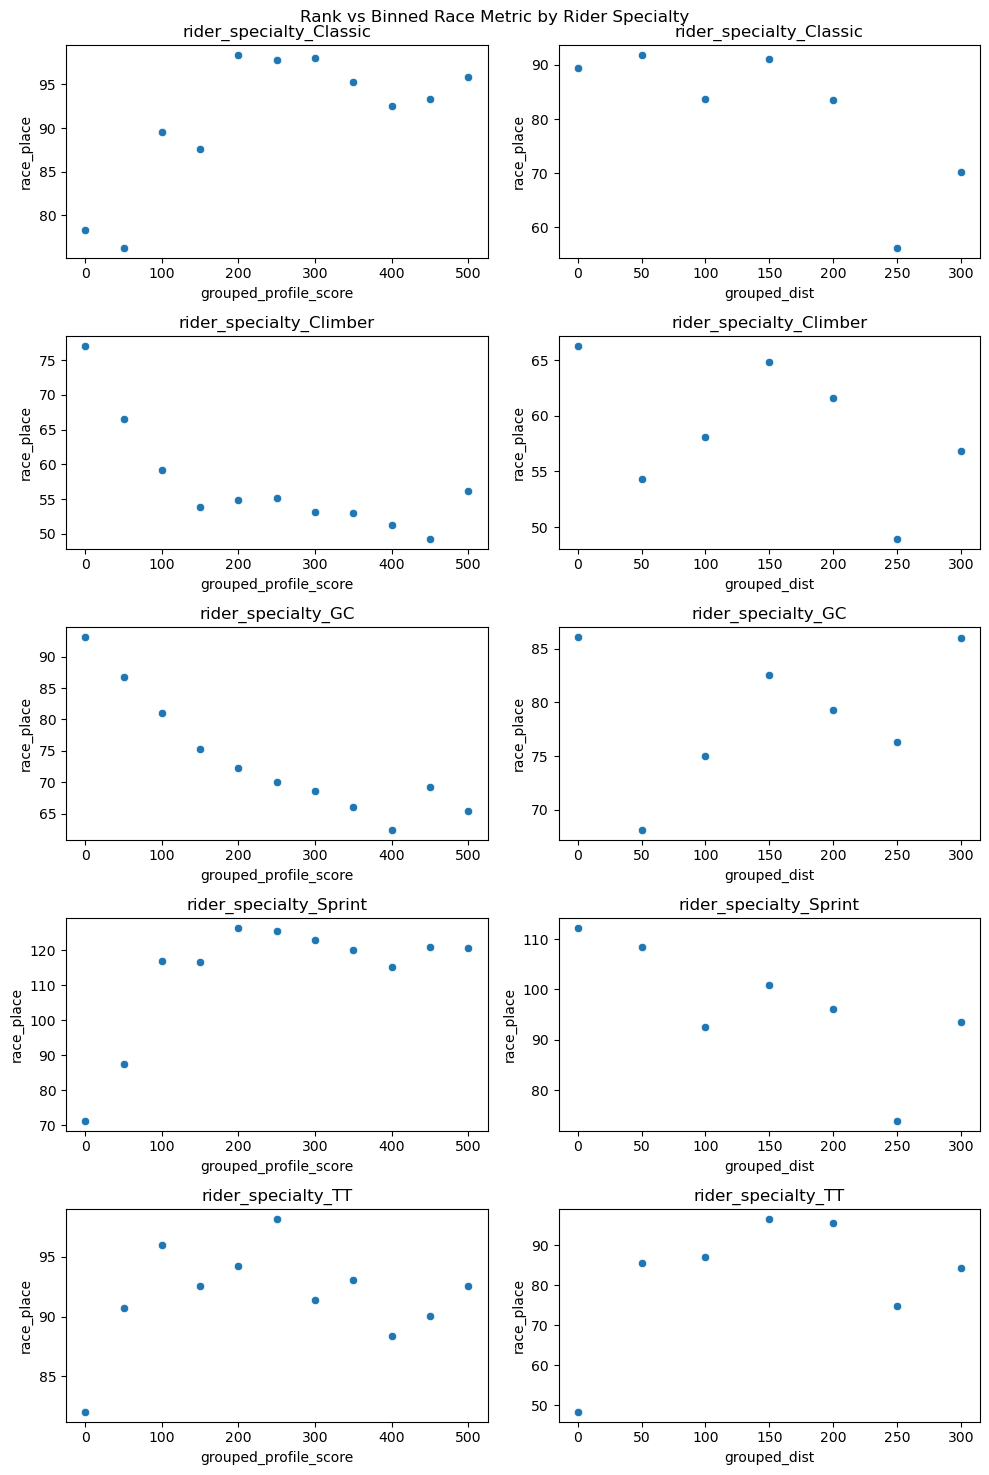

In [45]:
fig, axs = plt.subplots(5,2, figsize=(10,15))
axs = axs.ravel()

specs = ['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 'rider_specialty_Sprint', 'rider_specialty_TT']

for sp in range(len(specs)):
    grouped = df2[df2[specs[sp]] == 1][['grouped_profile_score', 'race_place']].groupby(by=['grouped_profile_score']).mean()
    sns.scatterplot(data = grouped, x = 'grouped_profile_score', y = 'race_place', ax = axs[2*sp])
    axs[2*sp].set_title(specs[sp])

    grouped2 = df2[df2[specs[sp]] == 1][['grouped_dist', 'race_place']].groupby(by=['grouped_dist']).mean()
    sns.scatterplot(data = grouped2, x = 'grouped_dist', y = 'race_place', ax = axs[2*sp+1])
    axs[2*sp+1].set_title(specs[sp])

plt.suptitle("Rank vs Binned Race Metric by Rider Specialty")
fig.tight_layout()

### **Note that a lot of visualizations in this notebook make use of 'binning', a technique that groups together observations by the independent variable and produces a single representative response value. This is due to the very large number of observations we have and the high variance that would create incredibly noisy plots.**

### Graph analysis and modeling direction explanation:

As evident in the plots above, there are distinct relationships between both `profile_score` and `dist` and `race_place` across the different rider specialties. Therefore, we are right to continue with distinguishing specialty using binary indicators. The plots clearly show that the categorical classifications of riders have predictive value in regard to their ranking based on course characteristics. Although the plots do not take heteroskedasticity within the bins into account, they serve as a good sanity check on this part of our predictor set.

## Building the Rider History Features (cont.)
To create the two historical features, `prof_score_his`' and `dist_hist`, we are going to regress over the rider's places in all races before that point, with regards to both distance and profile score. For each, we are going to use a simple linear regression, and then use the resulting coefficient as the respective feature.

This enables us to get a historical record of each riders' performance on a variety of courses with different features. When combined with the rider specialty predictors, we will have a complete set of predictors that can incorporate information about both the rider and the course in predicting performance.

#### NOTE: The below cell is commented out. This is because it takes forever to run. Instead, for ease of computation and in an effort to save the teaching staff some time, we ran it once and exported it to a csv. The results can be loaded in as "results_with_coefs.csv" as done below

In [46]:
# PLEASE KEEP THIS COMMENTED
# THIS IS THE ONE WITH ALL OF THEM

# from sklearn.linear_model import LinearRegression

# dates = list(df['race_date'].unique())

# df['dist_history'] = np.ones(len(df.index))
# df['profile_score_history'] = np.ones(len(df.index))
# for d in dates:
#     dftemp = df.copy()
#     dftemp = dftemp[dftemp['race_date'] < d]

#     riders = dftemp['rider_name'].unique()
    
#     for rider in riders:
#         dftemp2 = dftemp[dftemp['rider_name'] == rider]
#         dists = dftemp2[['race_dist']]
#         pss = dftemp2[['race_profile_score']]
#         response = dftemp2['response']

#         dist_model = LinearRegression().fit(dists, response)
#         pss_model = LinearRegression().fit(pss, response)

#         df.loc[(df['rider_name'] == rider) &
#                            (df['race_date'] == d),'dist_history'] = dist_model.coef_[0]
#         df.loc[(df['rider_name'] == rider) &
#                     (df['race_date'] == d), 'profile_score_history'] = pss_model.coef_[0]
#     print(f'Done with date {d}..')
# print('Done with making predictors')

In [47]:
# PLEASE KEEP THIS COMMENTED
#This saves the results after the fit in the above cell
#df.to_csv('results_with_coefs.csv', index=False)

In [48]:
#Importing the results that we just exported
df = pd.read_csv('results_with_coefs.csv')

#### The below cell trims away the following values from our train set:
- Those with `profile_score_history` (and therefore also `dist_history`) of 0: These rows represent the first race a rider completed, so there are no historical performances from which to calculate a historical feature. Since these have no predictive value, it is best to remove them to avoid them dragging overall predictive power of the variables toward 0.
- Those with absolute value of profile_score_history or dist_history greater than 1: These come within the first few races where we predict the coefficients for `race_place` on profile score and distance - these are very noisy as compared to the "true" stablized coefficients we observe in later races. Because of this, it is best to remove them to get a robust, low-variance set of predictors.

In [49]:
trimmed_df = df[(df['dist_history'].notna()) & (df['profile_score_history'].notna()) &
               (df['profile_score_history'] != 0) &
               (abs(df['profile_score_history']) < 1) &
               (abs(df['dist_history']) < 1)].copy()

#### As a sanity check, let's look at the progression of one racer's calculated profile_score_history and distance_history:

Text(0.5, 0.98, 'Carlos Barbero profile_score_history and dist_history Values over time')

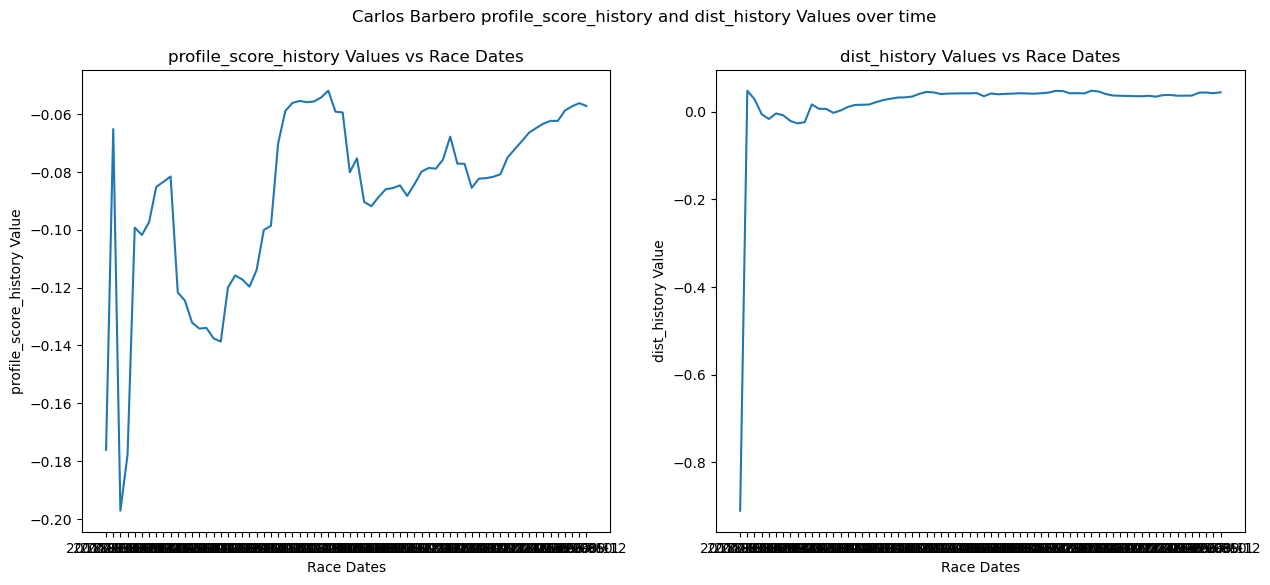

In [50]:
bm = trimmed_df[trimmed_df['rider_name'] == 'BARBERO Carlos']
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(bm['race_date'],bm['profile_score_history'])
ax[0].set_xlabel('Race Dates')
ax[0].set_ylabel('profile_score_history Value')
ax[0].set_title('profile_score_history Values vs Race Dates')

ax[1].plot(bm['race_date'],bm['dist_history'])
ax[1].set_xlabel('Race Dates')
ax[1].set_ylabel('dist_history Value')
ax[1].set_title('dist_history Values vs Race Dates')


plt.suptitle('Carlos Barbero profile_score_history and dist_history Values over time')

As expected, these historical features stabilize over time as the regression is trained on an increasing sample size of prior races. We see that later races can still affect the coefficient if the racer has an exceptionally strong or weak performance.

## Model Fitting:

### Baseline Model

Below, we implement our first baseline model. 

We have to be very careful not to use race results from races after the race we are trying to predict in predicting the current race. For instance, we cannot use race data from August 2023 in predicting race results for a race from July 2023 (for testing purposes). This is because, though we are training our model(s) blindly (ie without racer name), each data point still has a coefficient relative to the racer's performance history for both distance and profile score (engineering explained above), and a lot could have changed for that racer within time. (Just think, if you ran a 6 minute mile in Ocotber, should you use that to predict how fast you ran a mile earlier that year in May? When you were averaging about a 10 minute mile? No, you could not, because at the time of predicting your mile time in May, that 6 minute October mile hadn't happened yet, and would strongly affect your data.)

Because our entire concept is very susceptible to data leakage, we must train our model chronologically, race by race. At each iteration, we train new model on all the races *that have happened already* to predict the next race. Again, this is because we cannot use future races to predict results of the past. 

To get a preliminary understanding of our results, we use a linear regression model as our baseline at each iteration. At each iteration, the linear regression is trained on all of the races prior, and predicts for the current iteration. This causes each iteration to have its own linear regression model and we will end up with n-1 models (n being the number of races; we don't predict the first race). For our baseline attempt, it produces pretty ok results, as shown below.


In [51]:
#make all races interact with created scores

trimmed_df['profile_score_coef_interact'] = trimmed_df['race_profile_score'] * trimmed_df['profile_score_history']
trimmed_df['dist_coef_interact'] = trimmed_df['race_dist'] * trimmed_df['dist_history']


import time

# Generate some example data
np.random.seed(42)

dates = list(trimmed_df['race_date'].unique())

results = []

#sgd_regressor = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
lin_model = LinearRegression()
for d in range(len(dates)-2):
    start = time.time()
    
    X_tr = trimmed_df[trimmed_df['race_date'] < dates[d+2]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
    'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    X_te = trimmed_df[trimmed_df['race_date'] == dates[d+2]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
    'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
    y_tr = trimmed_df[trimmed_df['race_date'] < dates[d+2]]['response']
    y_te = trimmed_df[trimmed_df['race_date'] == dates[d+2]]['response']

    #fitted_model = sgd_regressor.partial_fit(X_tr, y_tr)
    fitted = lin_model.fit(X_tr, y_tr)

    end = time.time()
    diff = end - start
    
    if d%50 == 0:
        print(f'Done with date number {d}..')
        print(f'The last race took {diff} seconds')

    # Make predictions on the test set
    y_pred = fitted.predict(X_te)
    results.append(y_pred)
print('Done with building model')
    

Done with date number 0..
The last race took 0.020142078399658203 seconds
Done with date number 50..
The last race took 0.02631402015686035 seconds
Done with date number 100..
The last race took 0.03902888298034668 seconds
Done with date number 150..
The last race took 0.04331183433532715 seconds
Done with date number 200..
The last race took 0.04199814796447754 seconds
Done with date number 250..
The last race took 0.04097914695739746 seconds
Done with date number 300..
The last race took 0.05507993698120117 seconds
Done with date number 350..
The last race took 0.051518917083740234 seconds
Done with date number 400..
The last race took 0.05148887634277344 seconds
Done with date number 450..
The last race took 0.06099724769592285 seconds
Done with building model


In [52]:
check = pd.DataFrame()

for d in range(len(dates)-2):
    start = time.time()
    
    temp = trimmed_df[trimmed_df['race_date'] == dates[d+2]][['race', 'race_date', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = results[d]
    
    bts = sorted(results[d], reverse=True)
    bts2 = results[d]
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check = pd.concat([check, temp])

In [53]:
check['abs_difference'] = np.abs(check['race_place'] - check['predicted_race_pl'])

In [54]:
# Understanding how races after 2022 were predicted/how accurate
new_races = check[check['race_date'] > '2022-01-01'].copy()

In [55]:
new_races

,race,race_date,rider_name,response,race_place,predicted_response,predicted_race_pl,abs_difference
50827,race/paris-nice/2022/stage-1,2022-03-06,DURBRIDGE Luke,11.588235,102.0,29.365702,115,13.0
50828,race/paris-nice/2022/stage-1,2022-03-06,SCHULTZ Nick,11.475728,103.0,43.596527,25,78.0
50829,race/paris-nice/2022/stage-1,2022-03-06,TEUNISSEN Mike,11.365385,104.0,33.162878,99,5.0
50830,race/paris-nice/2022/stage-1,2022-03-06,VAN HOOYDONCK Nathan,11.257143,105.0,36.513502,77,28.0
50831,race/paris-nice/2022/stage-1,2022-03-06,VINE Jay,11.150943,106.0,45.504949,16,90.0
...,...,...,...,...,...,...,...,...
74765,race/il-lombardia/2023,2023-10-07,FUGLSANG Jakob,17.725806,62.0,74.818064,10,52.0
74766,race/il-lombardia/2023,2023-10-07,BENOOT Tiesj,17.444444,63.0,46.046506,50,13.0
74767,race/il-lombardia/2023,2023-10-07,MONIQUET Sylvain,17.171875,64.0,45.344339,52,12.0
74768,race/il-lombardia/2023,2023-10-07,JANSSENS Jimmy,12.348315,89.0,38.307780,82,7.0


In [56]:
# helper function to group and visualize
def group_places(val):
    val_ranges = [
        {'low': 0, 'high': 10},
        {'low': 10, 'high': 20},
        {'low': 20, 'high': 30},
        {'low': 30, 'high': 40},
        {'low': 40, 'high': 50},
        {'low': 50, 'high': 60},
        {'low': 60, 'high': 70},
        {'low': 70, 'high': 80},
        {'low': 80, 'high': 90},
        {'low': 90, 'high': 100},
        {'low': 100, 'high': 110},
        {'low': 110, 'high': 120},
        {'low': 120, 'high': 130},
        {'low': 130, 'high': 140},
        {'low': 140, 'high': 150},
        {'low': 150, 'high': 160},
        {'low': 160, 'high': 170},
        {'low': 170, 'high': 180},
        {'low': 180, 'high': 250}
    ]
    for r in val_ranges:
        if (val >= r['low']) & (val < r['high']):
            new_val = r['low']
    return new_val

# Call helper function
new_races['grouped_places'] = list(map(lambda x: group_places(x), new_races['race_place']))

In [57]:
new_races

,race,race_date,rider_name,response,race_place,predicted_response,predicted_race_pl,abs_difference,grouped_places
50827,race/paris-nice/2022/stage-1,2022-03-06,DURBRIDGE Luke,11.588235,102.0,29.365702,115,13.0,100
50828,race/paris-nice/2022/stage-1,2022-03-06,SCHULTZ Nick,11.475728,103.0,43.596527,25,78.0,100
50829,race/paris-nice/2022/stage-1,2022-03-06,TEUNISSEN Mike,11.365385,104.0,33.162878,99,5.0,100
50830,race/paris-nice/2022/stage-1,2022-03-06,VAN HOOYDONCK Nathan,11.257143,105.0,36.513502,77,28.0,100
50831,race/paris-nice/2022/stage-1,2022-03-06,VINE Jay,11.150943,106.0,45.504949,16,90.0,100
...,...,...,...,...,...,...,...,...,...
74765,race/il-lombardia/2023,2023-10-07,FUGLSANG Jakob,17.725806,62.0,74.818064,10,52.0,60
74766,race/il-lombardia/2023,2023-10-07,BENOOT Tiesj,17.444444,63.0,46.046506,50,13.0,60
74767,race/il-lombardia/2023,2023-10-07,MONIQUET Sylvain,17.171875,64.0,45.344339,52,12.0,60
74768,race/il-lombardia/2023,2023-10-07,JANSSENS Jimmy,12.348315,89.0,38.307780,82,7.0,80


In [58]:
grouped = new_races[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped['predicted_race_place_adjusted'] = list(map(lambda x: 4*(x - 50), grouped['predicted_race_pl']))
display(grouped.describe())
grouped

,response,race_place,predicted_response,predicted_race_pl,abs_difference,predicted_race_place_adjusted
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,32.646995,94.158352,35.689897,77.176053,47.847278,108.704212
std,67.648189,55.638837,6.265591,15.834835,18.132588,63.339340
min,5.370350,5.201606,29.246651,49.666667,35.081646,-1.333333
25%,7.951705,49.508544,30.972836,67.166517,37.529300,68.666066
50%,11.223428,94.452365,34.382961,77.838668,39.200257,111.354670
75%,21.553482,139.331598,37.844347,89.638262,51.401191,158.553048
max,303.110841,180.250000,50.327214,98.523913,106.750000,194.095652


,response,race_place,predicted_response,predicted_race_pl,abs_difference,predicted_race_place_adjusted
grouped_places,,,,,,
0,303.110841,5.201606,50.327214,49.666667,45.194378,-1.333333
10,75.251053,14.500000,48.084682,50.060976,39.200257,0.243902
20,43.365891,24.507386,43.888352,55.290302,38.988439,21.161207
30,30.740914,34.506701,41.939975,58.834716,37.276324,35.338864
40,23.782546,44.519330,38.364824,65.318299,37.724227,61.273196
50,19.324417,54.497758,37.323870,69.014734,37.470211,76.058937
60,16.398113,64.485323,35.853782,73.277886,37.588389,93.111546
70,14.187434,74.503583,34.863678,76.906189,35.766775,107.624756
80,12.503894,84.485304,34.382961,77.838668,35.081646,111.354670


In the table above, we can see that our models on average predict higher finishes for racers who finished high in reality and lower finishes for racers who finished low in reality. This is demonstrated by the fact that the `predicted_race_place` column increases with increases in the `race_place` column. We mesaure loss as the mean absolute deviation between predicted race place and observed race place. We can see that it is on the order of about 40 places away from what is observed on average.

In [59]:
# Append a new row to the DataFrame
results_df = pd.DataFrame({'model': ['Baseline Linear Model', 'Baseline Random Model'], 'test results': [grouped['abs_difference'].mean(), 75]})
results_df

,model,test results
0,Baseline Linear Model,47.847278
1,Baseline Random Model,75.000000


### Visual Analysis:

In the plots below, the distinct horizontal line represents what a random baseline predictor would predict. Because we are analyzing predictions on a binned basis, a random predictor would average the average number of places in every bin, which is calculated to be 

As we can see from the plot on the left, the raw predictions have a strong linear relationship with the actual rank, but as we can see the relationship is not right considering placements are truncated to be between 50-100 for the predicted ranks. This is something we will look into improving on in the model fitting going forward, but it is promising to observe a strong positive correlation between the predicted and actual ranks.

However, we do predict the middle of the pack from about 60-80 pretty well, as indicated by the intersection of our predictions with the 1:1 prediction line.

As a way of displaying what we believe is a more accurate representation of what the model can achieve, we can turn to the right plot which shows the same correlation by making a simple transformation to all the predicted values. 

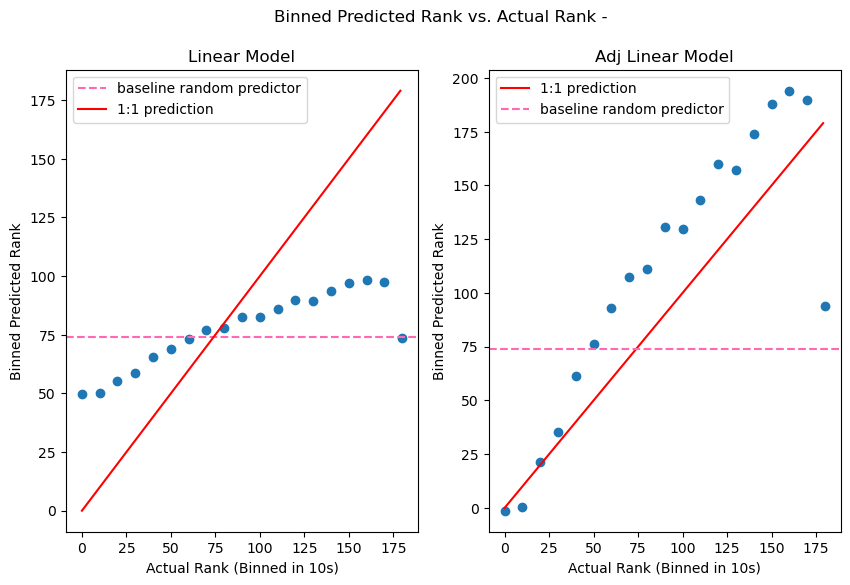

In [60]:
# show 1:1 predition
x =np.arange(min(grouped.index), max(grouped.index), 1)
av = (min(grouped['predicted_race_pl']) + max(grouped['predicted_race_pl']))/2
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax[0].plot(x, x, label = '1:1 prediction', color='red')
ax[0].scatter(grouped.index, grouped['predicted_race_pl'])
ax[0].set_title('Linear Model')
ax[0].set_xlabel('Actual Rank (Binned in 10s)')
ax[0].set_ylabel('Binned Predicted Rank')
ax[0].legend()

ax[1].plot(x, x, label = '1:1 prediction', color='red')
ax[1].scatter(grouped.index, grouped['predicted_race_place_adjusted'])
ax[1].axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax[1].set_title('Adj Linear Model')
ax[1].set_xlabel('Actual Rank (Binned in 10s)')
ax[1].set_ylabel('Binned Predicted Rank')
ax[1].legend()

plt.suptitle('Binned Predicted Rank vs. Actual Rank -');

### Separation Modeling:

Before trying to improve on this baseline model, we also wanted to establish some baseline model performance without the iterative training, where we ignored the aforementioned problem of data leakage. This would allow us to make more informed predictions for a larger number of races. 

#### Train/Test Split:
In order to do this, we separated the races into a training set and a test set based on the date: races before 2022 were included in the training set and races in 2022 and 2023 were included in the test set. We tried 3 different regression methods: linear regression, polynomial regression, and decision tree regression (using bagging).

In [61]:
# create interaction terms
trimmed_df['profile_score_coef_interact'] = trimmed_df['race_profile_score'] * trimmed_df['profile_score_history']
trimmed_df['dist_coef_interact'] = trimmed_df['race_dist'] * trimmed_df['dist_history']
trimmed_df['race_date'] = pd.to_datetime(trimmed_df['race_date'])

# create variable to capture how long ago race was
most_recent_race_date = trimmed_df['race_date'].max()
trimmed_df['days_since'] = (most_recent_race_date - trimmed_df['race_date'] ).dt.days

trimmed_df.head()

,race,race_place,rider_name,rider_age,race_date,race_dist,race_elev_gain,race_startlist_qual,race_profile_score,response,rider_specialty_Classic,rider_specialty_Climber,rider_specialty_GC,rider_specialty_Sprint,rider_specialty_TT,dist_history,profile_score_history,profile_score_coef_interact,dist_coef_interact,days_since
306,race/paris-nice/2018/stage-3,89.0,ROSA Diego,28,2018-03-06,210.0,2380.0,936,79.0,10.516854,0,1,0,0,0,0.225617,-0.279335,-22.067484,47.379553,2041
308,race/paris-nice/2018/stage-3,87.0,SLAGTER Tom-Jelte,28,2018-03-06,210.0,2380.0,936,79.0,10.758621,0,1,0,0,0,-0.165698,0.205150,16.206811,-34.796512,2041
309,race/paris-nice/2018/stage-3,86.0,SABATINI Fabio,33,2018-03-06,210.0,2380.0,936,79.0,10.883721,0,0,0,1,0,0.034473,-0.042681,-3.371785,7.239325,2041
310,race/paris-nice/2018/stage-3,85.0,VAN LERBERGHE Bert,25,2018-03-06,210.0,2380.0,936,79.0,11.011765,0,0,0,1,0,-0.100478,0.124402,9.827751,-21.100478,2041
311,race/paris-nice/2018/stage-3,84.0,DECLERCQ Tim,28,2018-03-06,210.0,2380.0,936,79.0,11.142857,1,0,0,0,0,0.008454,-0.010467,-0.826909,1.775398,2041


In [62]:
# create training set (races before 2022)
train_df = trimmed_df[trimmed_df['race_date'].dt.year < 2022]

X_train = train_df[['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
    'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact', 'days_since']]

y_train = train_df[['response']]


# create test set (after 2022)
test_df = trimmed_df[trimmed_df['race_date'].dt.year >= 2022]

X_test = test_df[['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
    'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact', 'days_since']]

y_test = test_df[['response']]

In [63]:
# Helper function that accepts 
#    a) the entire training / test set (train_df or test_df), and
#    b) the corresponding predictions for the `response` variable from a model 
# and outputs a data frame with columns including predicted stage score ('pred_response') and 
# predicted race place ('pred_rank')

def calc_pred_rank(pred_df, pred):

    pred_df = pred_df.copy()
    # column for model predictions
    pred_df['pred_response'] = pred

    # initializes column for predicted rank place (to be calculated from model predictions)
    pred_df['pred_rank'] = 0 

    # list of races to create unique race place order for each individual race within train / test set
    races = pred_df['race'].unique()

    for race in races:
        # subset of output dataframe corresponding to single race
        race_df = pred_df.copy()
        race_df = race_df[race_df['race'] == race]

        # gets predicted response in list format, sorted and unsorted
        pred_response_sorted = race_df[['pred_response']].sort_values(
            'pred_response', ascending = False).values.tolist()
        pred_response = race_df[['pred_response']].values.tolist()

        # creates list of predicted rank places by matching unsorted list to
        # ordered list and adds it to race dataframe
        pred_order = []
        for pred in pred_response:
            pred_order.append(pred_response_sorted.index(pred) + 1)
        race_df['pred_rank'] = pred_order

        # merges individual race data frame with copy of train / test set for output
        pred_df.loc[race_df.index, 'pred_rank'] = race_df['pred_rank']

    return pred_df        

### Measuring Prediction Error
We felt it was an important to create an _interpretable_ measure of error given the context of our project. Thus, we decided to look at the mean absolute deviation of the predicted race places from the actual race places. This way, the magnitude of our errors will be much easier to understand and compare. The following function accepts an output from the `calc_pred_rank` function above and returns our chosen measure of error for those predictions, while storing the deviation and absolute deviation measures for visual inspection.

In [64]:
# Helper function that scores model by taking mean absolute deviation of predicted race place from actual race place
def pred_rank_scorer(results):
    results['deviation'] = results['race_place'] - results['pred_rank']
    results['abs_deviation'] = abs(results['deviation'])
    return round(results['abs_deviation'].mean(),4)

### Linear Regression Prediction
To set a baseline for our predictive models with this train/test-scheme, we can begin by fitting a linear regression to the train data to get an initial measure of the predictive value of the historical data.

In [65]:
lr = LinearRegression().fit(X_train, y_train)

lr_train_results = calc_pred_rank(train_df, lr.predict(X_train))
lr_test_results = calc_pred_rank(test_df, lr.predict(X_test))

print(pred_rank_scorer(lr_train_results), pred_rank_scorer(lr_test_results))

42.4661 40.5958


In [66]:
temp_res = pd.DataFrame({'model': ['Linear Regression Prediction: Separated'], 'test results': [pred_rank_scorer(lr_test_results)]})
results_df = pd.concat([results_df, temp_res])
results_df

,model,test results
0,Baseline Linear Model,47.847278
1,Baseline Random Model,75.000000
0,Linear Regression Prediction: Separated,40.595800


Text(0.5, 0, 'Race Place')

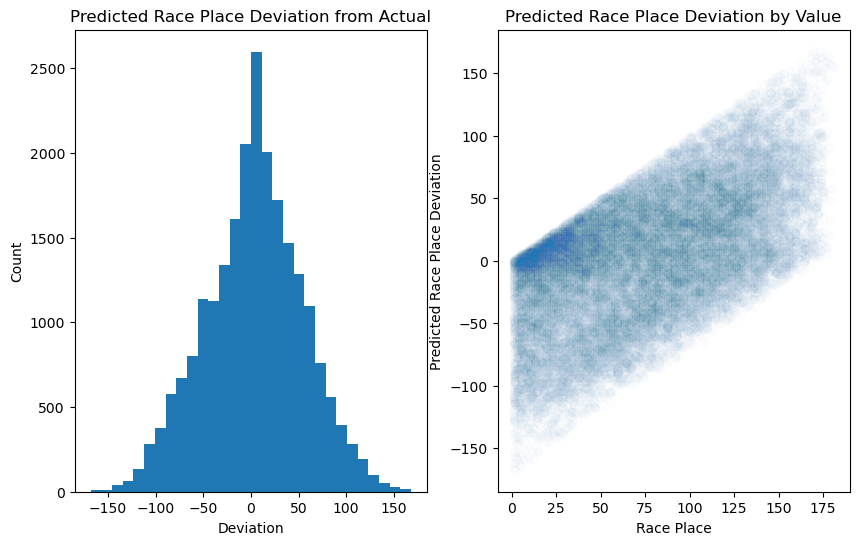

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs = axs.ravel()

axs[0].hist(lr_test_results['deviation'], bins = 30)
axs[0].set_title('Predicted Race Place Deviation from Actual')
axs[0].set_xlabel('Deviation')
axs[0].set_ylabel('Count')

axs[1].scatter(lr_test_results['race_place'], lr_test_results['deviation'], alpha = 0.01)
axs[1].set_title('Predicted Race Place Deviation by Value')
axs[1].set_ylabel('Predicted Race Place Deviation')
axs[1].set_xlabel('Race Place')

### Graph Interpretations
As can be seen from above, the errors are symmetric and normally distributed around 0, with the overwhelming number of results having an error +-25 places. We can see from the right plot that the predictions seem to be the best for the first 50 places, which makes sense when considering that the top 50 places are where riders will fight to the bitter end and rider capacity will be the most crystallized, while the last 100 spots likely consist of riders fighting less for the places and higher variance depending on equipment issues etc., which decreases the predictive value of historical attributes.

### Polynomial Regression Prediction

Building on the most standard linear prediction, we can implement polynomial degrees in an effort to get more interprative value. We use cross validation to determine the best polynomial-degree and choose the optimal degree based on the lowest validation mean absolute error (in the spirit of being consistent with our selected loss measure).

In [68]:
cv_val_mse_means_poly = []
cv_train_mse_means_poly = []

for i in range(1,5):
    poly_train = PolynomialFeatures(degree=i, include_bias=False).fit(X_train)
    X_poly_train = poly_train.transform(X_train)
    
    mse_scores = cross_validate(LinearRegression(), X_poly_train, y_train, cv = 5,
                                scoring = 'neg_mean_squared_error', return_train_score=True)
    mse_val_mean = -np.mean(mse_scores['test_score'])
    mse_train_mean = -np.mean(mse_scores['train_score'])
    cv_val_mse_means_poly.append(mse_val_mean)
    cv_train_mse_means_poly.append(mse_train_mean)

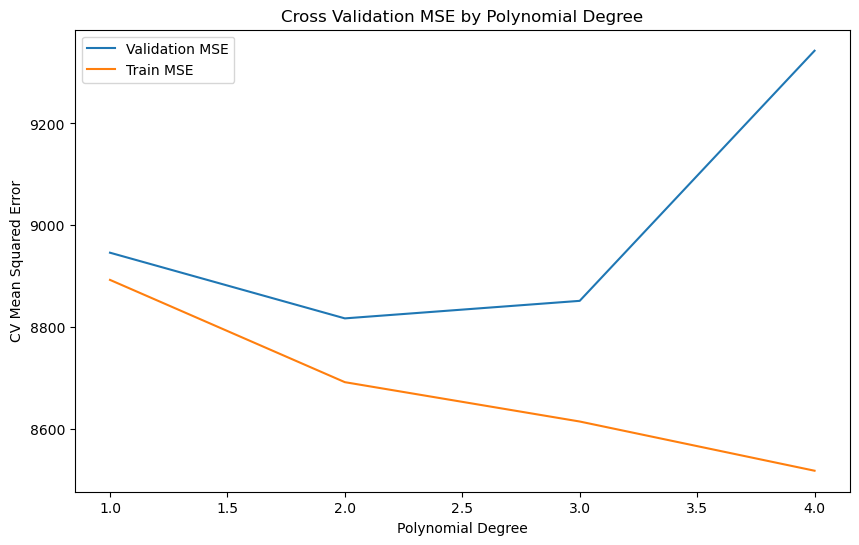

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(np.arange(1,5), cv_val_mse_means_poly, label = 'Validation MSE')
ax.plot(np.arange(1, 5), cv_train_mse_means_poly, label = 'Train MSE')
ax.set_title('Cross Validation MSE by Polynomial Degree')
ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('CV Mean Squared Error')
ax.legend();

### Graph Interpretations
Using mean squared error indicates 2 is best degree, as it minimizes validation MSE. Because our method of loss for model optimization is MSE of the response variable rather than place deviation, the optimal degree to use is 2.

In [70]:
best_degree = 2

poly = PolynomialFeatures(degree=best_degree, include_bias=False).fit(X_train)
X_poly_train = poly.transform(X_train)
X_poly_test = poly.transform(X_test)

lr_poly = LinearRegression().fit(X_poly_train, y_train)

poly_train_results = calc_pred_rank(train_df, lr_poly.predict(X_poly_train))
poly_test_results = calc_pred_rank(test_df, lr_poly.predict(X_poly_test))

print('Mean absolute deviations in predicted ranks for the polynomial model is:')
print('Train -- Test')
print(pred_rank_scorer(poly_train_results), pred_rank_scorer(poly_test_results))

Mean absolute deviations in predicted ranks for the polynomial model is:
Train -- Test
41.345 41.8009


In [71]:
temp_res = pd.DataFrame({'model': ['Polynomial Regression Prediction: Separated'], 'test results': [pred_rank_scorer(poly_test_results)]})
results_df = pd.concat([results_df, temp_res])
results_df

,model,test results
0,Baseline Linear Model,47.847278
1,Baseline Random Model,75.000000
0,Linear Regression Prediction: Separated,40.595800
0,Polynomial Regression Prediction: Separated,41.800900


In [72]:
print('The optimal train and test MSEs for polynomial prediction are:')
print('Train -- Test')
print(mean_squared_error(y_train, lr_poly.predict(X_poly_train)),
mean_squared_error(y_test, lr_poly.predict(X_poly_test)))

The optimal train and test MSEs for polynomial prediction are:
Train -- Test
8701.01251337329 8661.702293508126


### Decision Tree Prediction
Now we can move to implement an alternative to the above regression-based predictions. A natural place to start is with a decision tree approach.

In [73]:
ks = np.arange(1,20)

# store train and test mses for single decision tree, as well as cross validation 
# mean squared error and mean absolute error
cvmse_val = []
cvmse_train = []

for k in ks:
    dt = DecisionTreeRegressor(max_depth = k)
    fitted_dt = DecisionTreeRegressor(max_depth = k).fit(X_train, y_train)

    cvmses = cross_validate(dt, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error',
    return_train_score=True)
    cvmse_val.append(-np.mean(cvmses['test_score']))
    cvmse_train.append(-np.mean(cvmses['train_score']))

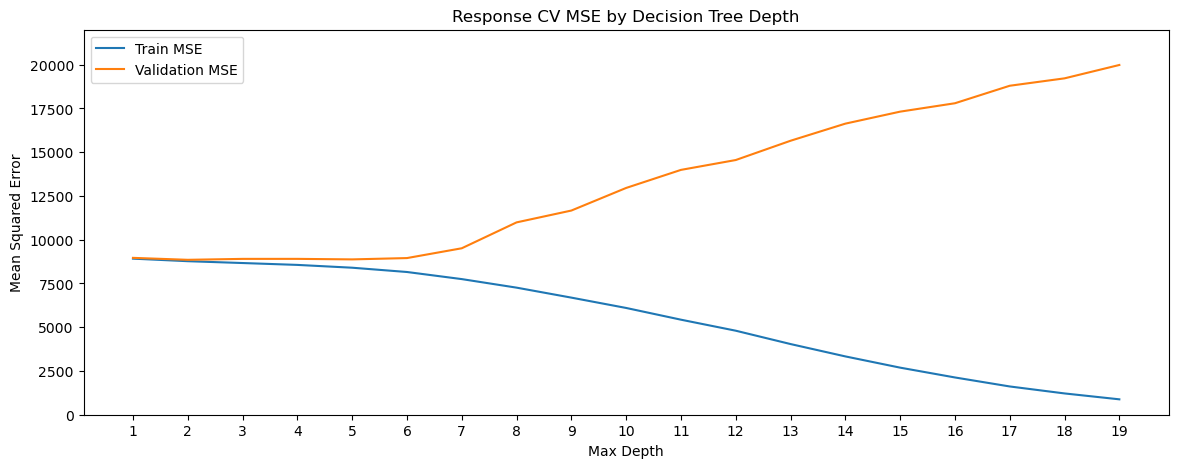

In [74]:
fig, ax = plt.subplots(1,1, figsize=(14, 5))

ax.plot(ks, cvmse_train, label = 'Train MSE')
ax.plot(ks, cvmse_val, label = 'Validation MSE')
ax.set_xticks(ks)
ax.set_xlabel('Max Depth')
ax.set_ylim(0, 22000) 
ax.set_title('Response CV MSE by Decision Tree Depth')
ax.set_ylabel('Mean Squared Error')
ax.legend();

In [75]:
#Now we can obtain the train and test MSE of our optimal-depth decision tree
optimal_depth = 6

optimal_dt = DecisionTreeRegressor(max_depth = optimal_depth).fit(X_train, y_train)

optimal_dt_train_mse = np.round(mean_squared_error(y_train, optimal_dt.predict(X_train)), 1)
optimal_dt_test_mse = np.round(mean_squared_error(y_test, optimal_dt.predict(X_test)), 1)

#Saving the results from the optimal dt prediction
dt_train_results = calc_pred_rank(train_df, optimal_dt.predict(X_train))
dt_test_results = calc_pred_rank(test_df, optimal_dt.predict(X_test))

print('The optimal train and test MSEs for decision tree prediction are:')
print('Train -- Test')
print(optimal_dt_train_mse, optimal_dt_test_mse)

The optimal train and test MSEs for decision tree prediction are:
Train -- Test
8218.8 8659.8


In [76]:
temp_res = pd.DataFrame({'model': ['Decision Tree Regressor Prediction: Separated'], 'test results': [pred_rank_scorer(dt_test_results)]})
results_df = pd.concat([results_df, temp_res])
results_df

,model,test results
0,Baseline Linear Model,47.847278
1,Baseline Random Model,75.000000
0,Linear Regression Prediction: Separated,40.595800
0,Polynomial Regression Prediction: Separated,41.800900
0,Decision Tree Regressor Prediction: Separated,39.064800


### Expanding on Decision Tree Prediction - Bagging
Although a Random Forest approach to ensemble prediction usually performs better than bagging, we believe the returns to implementing Random Forest in this case is quite small due to the small number of predictors we leverage.
We have five binary categorical predictors among which any individual can only belong to 1, meaning that RF likely would have very limited returns among those, and aside from those the 3 other predictors adress quite distinct elements of a rider's capabilities, leading us to believe that they likely will be utilized regardless, which we can explore further down in our analysis. In either case, we move forward with implementing a bagging-based ensemble model.

### Choosing Bagging Parameters
As we know from class, the choice of bootstraps in bagging should be large enough to where the deepness of the trees do not lead to overfitting. We will therefore iterate over the options of 10 - 50 trees, and see how the performance of the model changes.

As for the deepness of the trees, we can see from the above CV that a depth of 20 clearly will overfit each individual tree. We can therefore use this as the max_depth of the individual trees in the bagging implementation.

In [ ]:
bag_depth = 10

choices_n = list(range(1,50,5))
mse_val = []
mse_train = []

for n in choices_n:
    bag = BaggingRegressor(DecisionTreeRegressor(max_depth=bag_depth), n_estimators=n, random_state=109)

    cvmses = cross_validate(bag, X_train, np.ravel(y_train), cv = 5, scoring = 'neg_mean_squared_error',
    return_train_score=True)
    mse_val.append(-np.mean(cvmses['test_score']))
    mse_train.append(-np.mean(cvmses['train_score']))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(choices_n, mse_val, label = 'Validation MSE')
ax.plot(choices_n, mse_train, label = 'Train MSE')
ax.set_title('Response MSE for # of Decision Trees - Bagging')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('# of Trees')
ax.legend();

### Optimal # of Trees
From visual inspection of the above results, we can see that the lowest validation error  seems to be achieved at 40 bootstraps, and we will therefore use that number for the optimal number of trees in the model.

In [ ]:
optimal_n_trees = 35

optimal_bag = BaggingRegressor(DecisionTreeRegressor(max_depth=bag_depth), n_estimators=optimal_n_trees,
random_state=109).fit(X_train, np.ravel(y_train))

bag_train_results = calc_pred_rank(train_df, optimal_bag.predict(X_train))
bag_test_results = calc_pred_rank(test_df, optimal_bag.predict(X_test))

print('Mean absolute deviations in predicted ranks for the Bagging model is:')
print('Train -- Test')
print(pred_rank_scorer(bag_train_results), pred_rank_scorer(bag_test_results))

In [ ]:
print('The optimal train and test MSEs for Bagging-based prediction are:')
print('Train -- Test')
print(mean_squared_error(y_train, optimal_bag.predict(X_train)),
mean_squared_error(y_test, optimal_bag.predict(X_test)))

## Current Model Evaluations:
As expected, we see that the mean absolute deviation of model performance on the training set decreases as we m ove from linear regression to polynomial regression to a decision tree to a bagging ensemble model. This makes sense because more complex models are able to fit the training set better (this order of models is in order of increasing complexity). With regards to the test scores, we see that the polynomial regression did slightly worse than the linear regression. This is unexpected, but indicates that our polynomial regression may have overfit the training set. We also see that the decision tree regressor had the best test performance (lowest mean absolute deviation) when compared to these two models, as expected, but also did better than the bagging model. Again, this is surprising as we would expect an ensemble method like bagging to perform better than a single decision tree regression. However, it is likely that our parameters might have led to overfitting of the training set within the bagging process, and that may have caused the single decision tree to have better test performance. Generally speaking, we saw that train and test error decreased with model complexity as expected,  that the single decision tree regression had the best test performance. This is evidence that the relationship between our predictors and rider race plank is non linear and methods like decision trees are better equipped for making predictions about cycling performance in this mattter:

In [ ]:
temp_res = pd.DataFrame({'model': ['Bagging Optimal # Trees Dtr Prediction: Separated'], 'test results': [pred_rank_scorer(bag_test_results)]})
results_df = pd.concat([results_df, temp_res])
results_df

## 209 Component: Blending

In the 209 advanced sections, we discussed the method of "blending". The concept of blending is taking multiple heterogenous learners and combining them into one final dataset in order to make a prediction. The driving motivator behind blending is to **decrease bias**. 

#### Here, we adapt the concept of blending. Below, we implement an ensemble methodology first using forward accumulation to create a meta model for each race. We explain the thinking as such:

- In order to predict the second race's results, we use a model that is solely trained on the first race, as there is no prior data available besides the first race.
- In order to predict the third race's results, we use a model that is an aggregation of two models: the first, the model that predicted the second race's result (just trained on the first race), and the second, a model trained on both the results of the first race and second race.
- In order to predict the fourth race's results, we use a model that is an aggregation of three models: the first, the model that predicted the second race's result (just trained on the first race), the second, a model trained on both the results of the first race and second race, and the third, a model trained on the results of the first, second, and third race.
 - This logic follows for the remaining races, the final race's ensemble being an aggregation of models starting with the first model trained on the first race's results, the final model aggregated trained on all races before the last race.

Considering the following inputs:

![inputs](inputs.png)

We can use the following model framework:

![Forward Accumulation](forward.png)

#### While all of the models will be trained on the same base model, they are different and cannot be considered the same model, as they are trained on different data. This contrasts a typical bagging methodoology, as in bagging, the data is bootstrapped, and in this case, each model is instead trained on its own dataset.

#### We implement such a blending strategy consistent with the motivation of blending: the hope of less bias in our model with more accurate results.  

#### Beacause of the unique structure of such framework, there are no pre-created functions or packages that work as we specifically intend. Therefore, to properly implement this ideology, we create our own framework from scratch:

#### We start with a base model of Linear Regression. 

In [ ]:
np.random.seed(42)

dates = list(trimmed_df['race_date'].unique())
models = []

for d in range(len(dates)-1):
    lin_model = LinearRegression()
    start = time.time()

    X_tr = trimmed_df[trimmed_df['race_date'] < dates[d+1]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
    'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
    y_tr = trimmed_df[trimmed_df['race_date'] < dates[d+1]]['response']

    # fit model and append it
    lin_model.fit(X_tr, y_tr)
    models.append(lin_model)
    
    end = time.time()
    diff = end - start
    
    if d%50 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

In [ ]:
check3 = pd.DataFrame()

for d in range(len(dates)-1):
    start = time.time()

    X_test = trimmed_df[trimmed_df['race_date'] == dates[d+1]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
    preds = []
    for i in range(d+1):
       preds.append(models[i].predict(X_test))

    
    temp = trimmed_df[trimmed_df['race_date'] == dates[d+1]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(preds)[:,x].mean() for x in range(len(preds[0]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check3 = pd.concat([check3, temp])
    end = time.time()
    diff = end - start
    
    if d%50 == 0: 
        print(f'Done with predicting model-date number {d}..')
        print(f'The last race took {diff} seconds')

In [ ]:
check3['abs_difference'] = np.abs(check3['race_place']-check3['predicted_race_pl'])
new_races2 = check3[check3['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races2['grouped_places'] = list(map(lambda x: group_places(x), new_races2['race_place']))
grouped2 = new_races2[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped2

In [ ]:
temp_res = pd.DataFrame({'model': ['Linear Blended Forward Accumulation'], 'test results': [grouped2['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Model/Graph Analysis:

As shown in the left graph, there seems to be a pretty good relationship from our predicted ranks and their actual ranks. However, the relationship we predict is still off from the true relationship, as proved by the red 1:1 prediction line. Not to mention, it performs worse than the other models we have already considered, as confirmed above with the test results, in relation to the average absolute race_place difference between prediction and true value.

It is further suggested that our predictions could be improved by a final linear transformation. We can further extend the idea of blending, in the capacity of adding in this linear transformation adjustment.

Consistent with the rest of our implementation, we must be conscious of data leakage. Therefore, we must go through in a by-model capacity to add this linear transformation adjustment.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(min(grouped2.index), max(grouped2.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
#ax[0].scatter(grouped2['predicted_race_pl'], grouped2.index, color='green')
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.scatter(grouped2.index, grouped2['predicted_race_pl'])
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.set_title('Binned Predicted Rank vs. Actual Rank - Forward Accumulative Blended Linear Model')
ax.legend()


### Implementing Linear Adjustment:
#### Consider the logic:

#### Issue 1: Our Model fits pretty well, but a linear transformation of our original predictions would significantly improve our predictions.

#### Solution 1: We can implement a linear adjustment to account for this, extending the idea of blending from a simple aggregation of the data to using a meta model that produces the final output.

#### Issue 2: Data leakage. We cannot use the current model's exact linear transformation to the true predictions as the Adjustment

#### Solution 2: We observe a pretty consistent relationship, thereforee we can use the last model's linear adjustment.
To understand this, consider the following example:
For the FOURTH race, the final model averages results from:
- a model trained on the first race's data
- a model trained on the first and second race's data
- a model trained on the first, second, and third race's data
While we CANNOT use the linear adjustment of the average of all the models,
we CAN use the linear adjustment of the previous, ie the predictions of the second race consisting of the model made of:
- a model trained on the first race's data
- a model trained on the first and second race's data
From the predictions it made from the third race's data

### We can implement a model with flow as such:

![Forward Accumulation Adjusted](forward_adj.png)

In [ ]:
reg_adj_mods = []

for d in check3['race_date'].unique():
    mod = LinearRegression()
    mod.fit(check3[check3['race_date'] == d][['predicted_response']], check3[check3['race_date'] == d]['response'])
    reg_adj_mods.append(mod)

d0 = check3['race_date'].unique()[0]
reg_adj_response = list(check3[check3['race_date'] == d0]['predicted_response'].values)
reg_adj_pls = list(check3[check3['race_date'] == d0]['predicted_race_pl'].values)

for i in range(len(check3['race_date'].unique())-1):
    d = check3['race_date'].unique()[i+1]
    x = check3[check3['race_date'] == d][['predicted_response']]
    preds = reg_adj_mods[i].predict(x)
    reg_adj_response.extend(preds)
    
    bts = sorted(preds, reverse=True)
    bts3 = [(bts.index(x)+1) for x in preds]
    reg_adj_pls.extend(bts3)

check3['reg_adj_response'] = reg_adj_response
check3['reg_adj_pls'] = reg_adj_pls
check3['abs_difference'] = np.abs(check3['race_place']- check3['reg_adj_pls'])
new_races2 = check3[check3['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races2['grouped_places'] = list(map(lambda x: group_places(x), new_races2['race_place']))
grouped2 = new_races2[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'reg_adj_pls', 'reg_adj_response', 'abs_difference']].groupby(['grouped_places']).mean()
grouped2

In [ ]:
temp_res = pd.DataFrame({'model': ['Linear Blended Forward Accumulation Adjusted'], 'test results': [grouped2['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Model/Graph Analysis:

#### Hmm, that did not work as intended. 

Both from the graph and the average absolute difference, it is apparent that rather than gaining accuracy, we lost some. Rather, it suggests that the relationship from model to model is not linear, and therefore we cannot use a meta-model based on a regression of prediction errors from the last race's ensemble to improve the predictions based on the current, at least for this instance.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(min(grouped2.index), max(grouped2.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.scatter(grouped2.index, grouped2['reg_adj_pls'])
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.set_title('Binned Predicted Rank vs. Actual Rank - Accumulative Blended Linear Model Linear Adjustment')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend();

#### Moving forward from this idea, let's go back to that of our original blending implementation. Now, let us consider an ensemble for each race, where each model in the respective race's ensemble is a model trained specifically on a singular race. Consider the examples:
- the second race will be predicted on a model trained on the first
- the third race will be predicted by an average of a model trained on the first race's data and a model trained on the second race's data
- the fourth race will be predicted by an average of a model trained on the first race's data, a model trained on the second race's data, and a model trained on the third race's data
- and so forth

Consider the flow:

![Singular](sing.png)

In [ ]:
np.random.seed(42)

dates = list(trimmed_df['race_date'].unique())
models_sing = []

for d in range(len(dates)-1):
    lin_model = LinearRegression()
    start = time.time()
    
    X_tr = trimmed_df[trimmed_df['race_date'] == dates[d]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
    'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
    y_tr = trimmed_df[trimmed_df['race_date'] == dates[d]]['response']

    # fit model and append it
    lin_model.fit(X_tr, y_tr)
    models_sing.append(lin_model)
    
    end = time.time()
    diff = end - start
    
    if d%50 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

In [ ]:
check4 = pd.DataFrame()

for d in range(len(dates)-1):
    start = time.time()

    X_test = trimmed_df[trimmed_df['race_date'] == dates[d+1]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
    preds = []
    for i in range(d+1):
       preds.append(models_sing[i].predict(X_test))

    
    temp = trimmed_df[trimmed_df['race_date'] == dates[d+1]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(preds)[:,x].mean() for x in range(len(preds[0]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check4 = pd.concat([check4, temp])
    end = time.time()
    diff = end - start
    
    if d%50 == 0: 
        print(f'Done with predicting model-date number {d}..')
        print(f'The last race took {diff} seconds')

In [ ]:
check4['abs_difference'] = np.abs(check4['race_place'] - check4['predicted_race_pl'])
new_races3 = check4[check4['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races3['grouped_places'] = list(map(lambda x: group_places(x), new_races3['race_place']))
grouped3 = new_races3[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped3

In [ ]:
temp_res = pd.DataFrame({'model': ['Linear Blended Singular'], 'test results': [grouped3['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Model/Graph Analysis:
This method did not work well at all, being the worst performer yet. As shown in the graph, there is very little accuracy in predictions. Also, again there was a significant increase in average absolute difference. This suggests that equally weighting all races without incorporating previously known data in each ensemble model is not the way to go.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(min(grouped3.index), max(grouped3.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.scatter(grouped3.index, grouped3['predicted_race_pl'])
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.set_title('Blended Singulars Linear Model')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend()


#### Before we completely move on from the idea of singular models by race, let's try the linear adjustment as we did above:

![Sing adj](sing_adj.png)

In [ ]:
reg_adj_mods = []

for d in check4['race_date'].unique():
    mod = LinearRegression()
    mod.fit(check4[check4['race_date'] == d][['predicted_response']], check4[check4['race_date'] == d]['response'])
    reg_adj_mods.append(mod)

d0 = check4['race_date'].unique()[0]
reg_adj_response = list(check4[check4['race_date'] == d0]['predicted_response'].values)
reg_adj_pls = list(check4[check4['race_date'] == d0]['predicted_race_pl'].values)

for i in range(len(check4['race_date'].unique())-1):
    d = check4['race_date'].unique()[i+1]
    x = check4[check4['race_date'] == d][['predicted_response']]
    preds = reg_adj_mods[i].predict(x)
    reg_adj_response.extend(preds)
    
    bts = sorted(preds, reverse=True)
    bts3 = [(bts.index(x)+1) for x in preds]
    reg_adj_pls.extend(bts3)

check4['reg_adj_response'] = reg_adj_response
check4['reg_adj_pls'] = reg_adj_pls
check4['abs_difference'] = np.abs(check4['race_place'] - check4['reg_adj_pls'])
new_races3 = check4[check4['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races3['grouped_places'] = list(map(lambda x: group_places(x), new_races3['race_place']))
grouped3 = new_races3[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'reg_adj_pls', 'reg_adj_response', 'abs_difference']].groupby(['grouped_places']).mean()
grouped3

In [ ]:
temp_res = pd.DataFrame({'model': ['Linear Blended Singular Adjusted'], 'test results': [grouped3['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Model/Graph Analysis:

While the above attempt took out bias relative to the first spike in the graph on the left, and decreased the average absolute difference in predicted place for later places, it was at the cost of getting worse in accuracy relative to the lower places.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(min(grouped3.index), max(grouped3.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.scatter(grouped3.index, grouped3['reg_adj_pls'])
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.set_title('Binned Predicted Rank vs. Actual Rank - Blended Singulars Linear Adjustment')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend();


### Finally, we will consider a backwards accumulation blending technique:

#### This is a similar process to the forward accumulation, however the logic is as follows:

- In order to predict the second race's results, we use a model that is solely trained on the first race, as there is no prior data available besides the first race.
- In order to predict the third race's results, we use a model that is an aggregation of two models: a model that was just trained on data from the second race, and the second, a model trained on both the results of the first race and second race.
- In order to predict the fourth race's results, we use a model that is an aggregation of three models: a model that was just trained on data for the third race, the second, a model trained on both the results of the third race and second race, and the third, a model trained on the results of the first, second, and third race.
 - This logic follows for the remaining races, the final race's ensemble being an aggregation of models starting with the first model trained on the second to last race's results, the final model aggregated trained on all races before the last race.

![Backwards](backwards.png)

#### Our intention with implementing a backwards accumulation blending technique is to again reduce bias, but to also give more weight to more recent results. 

#### Unlike the forward accumulation, in which you could utilize the last race's ensemble in the create of the next, the backwards accumulation needs to calculate sub-ensemble models for all of the sub-models in the race's ensemble. Naturally, this is very computationally expensive. Therefore, in this case, we only consider the last 50 races, and do not attempt to include a linear adjustment as we did in the previous blending methods.

## *Note: even with the limitation of races, the next following blocks of code do take an extensive amount of time to run. Avoid if possible.

In [ ]:
dates_rev = list(trimmed_df['race_date'].unique())[::-1]
last50 = dates_rev[:51]
models_rev_ex = []

for d in range(len(last50)-1):
    models_rev_in = []
    start = time.time()
    for i in range(len(dates_rev[d+1:])):
        
        
        lin_model = LinearRegression()
        
        X_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev[d+1:][i]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
            'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
        y_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev[d+1:][i]]['response']

        # fit model and append it
        lin_model.fit(X_tr, y_tr)
        models_rev_in.append(lin_model)

    models_rev_ex.append(models_rev_in)

    end = time.time()
    diff = end - start
    
    if d%10 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')
        

In [ ]:
check5 = pd.DataFrame()

preds = []
for d in range(len(last50)-1):
    print("For race on: ", last50[d])
    start = time.time()
    
    # define test set
    X_test = trimmed_df[trimmed_df['race_date'] == dates_rev[d]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    in_preds = []
    for i in range(len(models_rev_ex[d])):
        in_preds.append(models_rev_ex[d][i].predict(X_test))

    preds.append(np.array(in_preds))
    temp = trimmed_df[trimmed_df['race_date'] == dates_rev[d]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(in_preds)[:,x].mean() for x in range(len(in_preds[d]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check5 = pd.concat([check5, temp])
    end = time.time()
    diff = end - start

    print(f'Done with predicting model-date number {d}..')
    print(f'The last race took {diff} seconds')
        

In [ ]:
check5['abs_difference'] = np.abs(check5['race_place'] - check5['predicted_race_pl'])
new_races4 = check5[check5['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races4['grouped_places'] = list(map(lambda x: group_places(x), new_races4['race_place']))
grouped4 = new_races4[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped4

In [ ]:
temp_res = pd.DataFrame({'model': ['Linear Blended Backward Accumulation 2018-2023'], 'test results': [grouped4['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Model/Graph Analysis:

This model seems already to be the best model relative to the blending methods. This is both by inspection and by test error. However, it is still not performing as well as some of the previous models. What if we eliminate the consideration of race data from races that were a long time ago, and limit our training window?

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(min(grouped4.index), max(grouped4.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.scatter(grouped4.index, grouped4['predicted_race_pl'])
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.set_title('Binned Predicted Rank vs. Actual Rank - BACKWARDS Accumulative Blended Models')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend();


#### Our previous blending models have all considered all of the data, from 2018 to 2023. First, let us train the model on races from 2020-2023, and then from 2022-2023 rather than all races from 2018-2023:

In [ ]:
dates_rev_20 = list(trimmed_df[trimmed_df['race_date'] >= '2020-01-01']['race_date'].unique())[::-1]
last50_20 = dates_rev_20[:51]
models_rev_20 = []

for d in range(len(last50_20)-1):
    models_rev_in = []
    start = time.time()
    for i in range(len(dates_rev_20[d+1:])):
        
        
        lin_model = LinearRegression()
        
        X_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev_20[d+1:][i]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
            'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
        y_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev_20[d+1:][i]]['response']

        # fit model and append it
        lin_model.fit(X_tr, y_tr)
        models_rev_in.append(lin_model)

    models_rev_20.append(models_rev_in)

    end = time.time()
    diff = end - start
    
    if d%10 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

check6 = pd.DataFrame()
for d in range(len(last50_20)-1):
    # print("For race on: ", last50_20[d])
    start = time.time()
    
    # define test set
    X_test = trimmed_df[trimmed_df['race_date'] == dates_rev_20[d]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    in_preds = []
    for i in range(len(models_rev_20[d])):
        in_preds.append(models_rev_20[d][i].predict(X_test))

    temp = trimmed_df[trimmed_df['race_date'] == dates_rev_20[d]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(in_preds)[:,x].mean() for x in range(len(in_preds[d]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check6 = pd.concat([check6, temp])
    end = time.time()
    diff = end - start

    print(f'Done with predicting model-date number {d}..')
    print(f'The last race took {diff} seconds')
        

In [ ]:
check6['abs_difference'] = np.abs(check6['race_place'] - check6['predicted_race_pl'])
new_races5 = check6[check6['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races5['grouped_places'] = list(map(lambda x: group_places(x), new_races5['race_place']))
grouped5 = new_races5[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped5

In [ ]:
temp_res = pd.DataFrame({'model': ['Linear Blended Backward Accumulation 2020-2022'], 'test results': [grouped5['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

In [ ]:
dates_rev_22 = list(trimmed_df[trimmed_df['race_date'] >= '2022-01-01']['race_date'].unique())[::-1]
last50_22 = dates_rev_22[:51]
models_rev_22 = []

for d in range(len(last50_22)-1):
    models_rev_in = []
    start = time.time()
    for i in range(len(dates_rev_22[d+1:])):
        
        
        lin_model = LinearRegression()
        
        X_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev_22[d+1:][i]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
            'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
        y_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev_22[d+1:][i]]['response']

        # fit model and append it
        lin_model.fit(X_tr, y_tr)
        models_rev_in.append(lin_model)

    models_rev_22.append(models_rev_in)

    end = time.time()
    diff = end - start
    
    if d%10 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

check7 = pd.DataFrame()
for d in range(len(last50_22)-1):
    # print("For race on: ", last50_22[d])
    start = time.time()
    
    # define test set
    X_test = trimmed_df[trimmed_df['race_date'] == dates_rev_22[d]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    in_preds = []
    for i in range(len(models_rev_22[d])):
        in_preds.append(models_rev_22[d][i].predict(X_test))

    temp = trimmed_df[trimmed_df['race_date'] == dates_rev_22[d]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(in_preds)[:,x].mean() for x in range(len(in_preds[d]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check7 = pd.concat([check7, temp])
    end = time.time()
    diff = end - start

    print(f'Done with predicting model-date number {d}..')
    print(f'The last race took {diff} seconds')
        

In [ ]:
check7['abs_difference'] = np.abs(check7['race_place'] - check7['predicted_race_pl'])
new_races6 = check7[check7['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races6['grouped_places'] = list(map(lambda x: group_places(x), new_races6['race_place']))
grouped6 = new_races6[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped6

In [ ]:
temp_res = pd.DataFrame({'model': ['Linear Blended Backward Accumulation 2022-2023'], 'test results': [grouped6['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Model(s)/Graph Analysis:

As demonstrated in the graphs, there is not a huge change from the three different year spanned considered. This is further supported by the little difference in testing errors. This is most likely due to the already over-arching framework of the backwards accumulation, which puts emphasis on more recent races rather than older ones, therefore there is not a significant difference between the three model's framework. The model that considers all of the data (trained on races from 2018-2023) is the most accurate among the three, but just barely, as seen in the graphs as well as comparing the average absolute place differences, with additional evidence of the lowest test error among the three. 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(min(grouped4.index), max(grouped4.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.scatter(grouped4.index, grouped4['predicted_race_pl'], label = '2018-2023', alpha=.5)
ax.scatter(grouped5.index, grouped5['predicted_race_pl'], color = 'green', label = '2020-2023', alpha=.5)
ax.scatter(grouped6.index, grouped6['predicted_race_pl'], color = 'purple', label = '2022-2023', alpha=.5)
ax.set_title('Binned Predicted Rank vs. Actual Rank - Backwards Accumulative Blended Models Comparing different Years')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend();


### Applying blending to DecisionTreeRegressor

As prediscussed, a singular DecisionTreeRegressor model is not great for our use-case. This is because training could result in multiple racers with the same place prediction, and in reality, this is not possible. 

At the same time, a linear regression model is also not great for our use-case, because it assumes a linear relationship among the features and response. 

A solution to both of these issues this is to use the blending techniques we used previously with a base model of linear regression with a base model of a decision tree regressor. 

By doing so, we significantly decrease the chances of multiple racers having the same race prediction (the more likely the more models we consider, therefore the later races chances are highest), as we take an aggregation of heterogenous model predictions. We also eliminate the linear relationship assumption.

In the following, we implement the forward accumulation by itself and with adjustment, the singular framework by itself and with adjustment, and the backwards accumulation considering the three different time windows.

#### As found in hyperparameter tuning above, we proceed with a max_depth=6 makes sense relative to both training and testing errors.

#### We first start with the forward accumulation as we did for linear regression, where the same model framework holds:
![forward accum](forward.png)


In [ ]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
dates = list(trimmed_df['race_date'].unique())

models_dtr = []

for d in range(len(dates)-1):
    dtr_model = DecisionTreeRegressor(random_state=42, max_depth=5)
    start = time.time()
    

    X_tr = trimmed_df[trimmed_df['race_date'] < dates[d+1]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
    'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
    y_tr = trimmed_df[trimmed_df['race_date'] < dates[d+1]]['response']

    # fit model and append it
    dtr_model.fit(X_tr, y_tr)
    models_dtr.append(dtr_model)
    
    end = time.time()
    diff = end - start
    
    if d%50 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

check3_dtr = pd.DataFrame()

for d in range(len(dates)-1):
    start = time.time()

    X_test = trimmed_df[trimmed_df['race_date'] == dates[d+1]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
    preds = []
    for i in range(d+1):
       preds.append(models_dtr[i].predict(X_test))

    
    temp = trimmed_df[trimmed_df['race_date'] == dates[d+1]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(preds)[:,x].mean() for x in range(len(preds[0]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check3_dtr = pd.concat([check3_dtr, temp])
    end = time.time()
    diff = end - start
    
    if d%50 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

In [ ]:
check3_dtr['abs_difference'] = np.abs(check3_dtr['race_place'] - check3_dtr['predicted_race_pl'])
new_races2_dtr = check3_dtr[check3_dtr['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races2_dtr['grouped_places'] = list(map(lambda x: group_places(x), new_races2_dtr['race_place']))
grouped2_dtr = new_races2_dtr[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped2_dtr

In [ ]:
temp_res = pd.DataFrame({'model': ['Decision Tree Blended Forward Accumulation'], 'test results': [grouped2_dtr['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Model/Graph Analysis:
As shown in the graphs, and backed by the test error, this model sits at the middle of the pack. The model struggled with fitting the lower places consistently, as well as the highest places. However, it continues to fit the middle portion well, and we would argue fits a larger span of the middle places better than previous models, supported by the average absolute difference values.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(min(grouped2_dtr.index), max(grouped2_dtr.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.scatter(grouped2_dtr.index, grouped2_dtr['predicted_race_pl'])
ax.set_title('Binned Predicted Rank vs. Actual Rank - Forward Accumulative Blended Decision Tree Regressor Model')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend();


### Again, let's extend the  adjustment- 
#### There is not a clear linear relationship in the above left graph, therefore the adjustment implemented is going to be another DecisionTreeRegressor

![forward adj](forward_adj.png)

In [ ]:
reg_adj_mods_dtr = []

for d in check3_dtr['race_date'].unique():
    mod = DecisionTreeRegressor(random_state=42, max_depth=5)
    #mod = LinearRegression()
    mod.fit(check3_dtr[check3_dtr['race_date'] == d][['predicted_response']], check3_dtr[check3_dtr['race_date'] == d]['response'])
    reg_adj_mods_dtr.append(mod)

d0 = check3['race_date'].unique()[0]
reg_adj_response_dtr = list(check3_dtr[check3_dtr['race_date'] == d0]['predicted_response'].values)
reg_adj_pls_dtr = list(check3_dtr[check3_dtr['race_date'] == d0]['predicted_race_pl'].values)

for i in range(len(check3_dtr['race_date'].unique())-1):
    d = check3_dtr['race_date'].unique()[i+1]
    x = check3_dtr[check3_dtr['race_date'] == d][['predicted_response']]
    preds = reg_adj_mods_dtr[i].predict(x)
    reg_adj_response_dtr.extend(preds)
    
    bts = sorted(preds, reverse=True)
    bts3 = [(bts.index(x)+1) for x in preds]
    reg_adj_pls_dtr.extend(bts3)

check3_dtr['reg_adj_response'] = reg_adj_response_dtr
check3_dtr['reg_adj_pls'] = reg_adj_pls_dtr
check3_dtr['abs_difference'] = np.abs(check3_dtr['race_place']- check3_dtr['reg_adj_pls'])
new_races2_dtr = check3_dtr[check3_dtr['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races2_dtr['grouped_places'] = list(map(lambda x: group_places(x), new_races2_dtr['race_place']))
grouped2_dtr = new_races2_dtr[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'reg_adj_pls', 'reg_adj_response', 'abs_difference']].groupby(['grouped_places']).mean()
grouped2_dtr

In [ ]:
temp_res = pd.DataFrame({'model': ['Decision Tree Blended Forward Accumulation Adjusted'], 'test results': [grouped2_dtr['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

#### Like the linear models, the adjustment did not execute as well as intended. The predictions were flattened significantly, and the predictions got worse across the board. 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(min(grouped2_dtr.index), max(grouped2_dtr.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.scatter(grouped2_dtr.index, grouped2_dtr['reg_adj_pls'])
ax.set_title('Binned Predicted Rank vs. Actual Rank - Accumulative Blended DTR Adjusted')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend()


### Now we proceed with the singular framework adapted to the DecisionTreeRegressor:
Reminder that this is when there is a model fitted to each race's data singularly and then the current race is predicted by an aggregation of the single models of the races before.
![sing](sing.png)

In [ ]:
np.random.seed(42)

dates = list(trimmed_df['race_date'].unique())
models_sing_dtr = []

for d in range(len(dates)-1):
    dtr_model = DecisionTreeRegressor(random_state=42, max_depth=5)
    start = time.time()
    
    X_tr = trimmed_df[trimmed_df['race_date'] == dates[d]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
    'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
    y_tr = trimmed_df[trimmed_df['race_date'] == dates[d]]['response']

    # fit model and append it
    dtr_model.fit(X_tr, y_tr)
    models_sing_dtr.append(dtr_model)
    
    end = time.time()
    diff = end - start
    
    if d%50 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

check4_dtr = pd.DataFrame()

for d in range(len(dates)-1):
    start = time.time()

    X_test = trimmed_df[trimmed_df['race_date'] == dates[d+1]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
    preds = []
    for i in range(d+1):
       preds.append(models_sing_dtr[i].predict(X_test))

    
    temp = trimmed_df[trimmed_df['race_date'] == dates[d+1]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(preds)[:,x].mean() for x in range(len(preds[0]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check4_dtr = pd.concat([check4_dtr, temp])
    end = time.time()
    diff = end - start
    
    if d%50 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

In [ ]:
check4_dtr['abs_difference'] = np.abs(check4_dtr['race_place'] - check4_dtr['predicted_race_pl'])
new_races3_dtr = check4_dtr[check4_dtr['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races3_dtr['grouped_places'] = list(map(lambda x: group_places(x), new_races3_dtr['race_place']))
grouped3_dtr = new_races3_dtr[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped3_dtr

In [ ]:
temp_res = pd.DataFrame({'model': ['Decision Tree Blended Singular Adjusted'], 'test results': [grouped3_dtr['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Model/Graph Analysis:

Just like with the linear version, the blended singular DecisionTreeRegressor models were not great at predicting race place and performed worse than the first forward accumulation. The average absolute difference does not perform well, and it does not outperform either the forward DTR blended model nor the backward linear model. It The model sturuggles to make difference in fitting anything, as the predicted ranks have a plateau of values- meaning that the variety large, and evens out to be about just as good, or even worse than a random predictor.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(min(grouped3_dtr.index), max(grouped3_dtr.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.scatter(grouped3_dtr.index, grouped3_dtr['predicted_race_pl'])
ax.set_title('Binned Predicted Rank vs. Actual Rank - Singular Blended Decision Tree Regressor Model')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend()

### Extending the adjustment again:
![sing adj](sing_adj.png)

In [ ]:
reg_adj_mods_dtr = []

for d in check4_dtr['race_date'].unique():
    mod = DecisionTreeRegressor(random_state=42, max_depth=5)
    #mod = LinearRegression()
    mod.fit(check4_dtr[check4_dtr['race_date'] == d][['predicted_response']], check4_dtr[check4_dtr['race_date'] == d]['response'])
    reg_adj_mods_dtr.append(mod)

d0 = check4['race_date'].unique()[0]
reg_adj_response_dtr = list(check4_dtr[check4_dtr['race_date'] == d0]['predicted_response'].values)
reg_adj_pls_dtr = list(check4_dtr[check4_dtr['race_date'] == d0]['predicted_race_pl'].values)

for i in range(len(check4_dtr['race_date'].unique())-1):
    d = check4_dtr['race_date'].unique()[i+1]
    x = check4_dtr[check4_dtr['race_date'] == d][['predicted_response']]
    preds = reg_adj_mods_dtr[i].predict(x)
    reg_adj_response_dtr.extend(preds)
    
    bts = sorted(preds, reverse=True)
    bts3 = [(bts.index(x)+1) for x in preds]
    reg_adj_pls_dtr.extend(bts3)

check4_dtr['reg_adj_response'] = reg_adj_response_dtr
check4_dtr['reg_adj_pls'] = reg_adj_pls_dtr
check4_dtr['abs_difference'] = np.abs(check4_dtr['race_place']- check4_dtr['reg_adj_pls'])
new_races3_dtr = check4_dtr[check4_dtr['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races3_dtr['grouped_places'] = list(map(lambda x: group_places(x), new_races3_dtr['race_place']))
grouped3_dtr = new_races3_dtr[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'reg_adj_pls', 'reg_adj_response', 'abs_difference']].groupby(['grouped_places']).mean()
grouped3_dtr

In [ ]:
temp_res = pd.DataFrame({'model': ['Decision Tree Blended Singular Adj'], 'test results': [grouped3_dtr['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Graph Analysis:

While the adjustment assisted the model in the capacity of making it less flat, the overarching performance is still not great. It is less flat than the unadjusted version, however still quite flat, meaning that the variety of predictions in is quite large and that it is not that accurate. Technically, the test error also increases.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(min(grouped3_dtr.index), max(grouped3_dtr.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.scatter(grouped3_dtr.index, grouped3_dtr['reg_adj_pls'])
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.set_title('Binned Predicted Rank vs. Actual Rank - Singular Blended DTR Adjusted')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend();

### And finally the backwards accumulation framework:

![Backwards](backwards.png)

#### We are still going to limit the races to 50 because of computation complexity, as well as forgoing the adjustment. We do proceed with the evaluation relative to training windows. Rather than split it up into two graphs as above, all three windows are only evaluated once in one graph.

## *Note: The following code blocks, though already reduced to account for time complexity, take an excruciating amount of time to run. Avoid unless necessary.

In [ ]:
dates_rev = list(trimmed_df['race_date'].unique())[::-1]
last50 = dates_rev[:51]
models_rev_ex_dtr = []

for d in range(len(last50)-1):
    models_rev_in_dtr = []
    start = time.time()
    for i in range(len(dates_rev[d+1:])):
        
        dtr_model = DecisionTreeRegressor(random_state=42, max_depth=5) 
        
        X_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev[d+1:][i]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
            'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
        y_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev[d+1:][i]]['response']

        # fit model and append it
        dtr_model.fit(X_tr, y_tr)
        models_rev_in_dtr.append(dtr_model)

    models_rev_ex_dtr.append(models_rev_in_dtr)

    end = time.time()
    diff = end - start
    
    if d%10 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

check5_dtr = pd.DataFrame()

preds = []
for d in range(len(last50)-1):
    print("For race on: ", last50[d])
    start = time.time()
    
    # define test set
    X_test = trimmed_df[trimmed_df['race_date'] == dates_rev[d]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    in_preds = []
    for i in range(len(models_rev_ex_dtr[d])):
        in_preds.append(models_rev_ex_dtr[d][i].predict(X_test))

    preds.append(np.array(in_preds))
    temp = trimmed_df[trimmed_df['race_date'] == dates_rev[d]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(in_preds)[:,x].mean() for x in range(len(in_preds[d]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check5_dtr = pd.concat([check5_dtr, temp])
    end = time.time()
    diff = end - start

    print(f'Done with fitting model-date number {d}..')
    print(f'The last race took {diff} seconds')
        

In [ ]:
check5_dtr['abs_difference'] = np.abs(check5_dtr['race_place'] - check5_dtr['predicted_race_pl'])
new_races4_dtr = check5_dtr[check5_dtr['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races4_dtr['grouped_places'] = list(map(lambda x: group_places(x), new_races4_dtr['race_place']))
grouped4_dtr = new_races4_dtr[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped4_dtr

In [ ]:
temp_res = pd.DataFrame({'model': ['Decision Tree Blended Backwards Accumulation 2018-2023'], 'test results': [grouped4_dtr['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

In [ ]:
dates_rev_20 = list(trimmed_df[trimmed_df['race_date'] >= '2020-01-01']['race_date'].unique())[::-1]
last50_20 = dates_rev_20[:51]
models_rev_20_dtr = []

for d in range(len(last50_20)-1):
    models_rev_in = []
    start = time.time()
    for i in range(len(dates_rev_20[d+1:])):
        
        dtr_model = DecisionTreeRegressor(random_state=42, max_depth=5)
        
        X_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev_20[d+1:][i]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
            'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
        y_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev_20[d+1:][i]]['response']

        # fit model and append it
        dtr_model.fit(X_tr, y_tr)
        models_rev_in.append(dtr_model)

    models_rev_20_dtr.append(models_rev_in)

    end = time.time()
    diff = end - start
    
    if d%10 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

check6_dtr = pd.DataFrame()
for d in range(len(last50_20)-1):
    # print("For race on: ", last50_20[d])
    start = time.time()
    
    # define test set
    X_test = trimmed_df[trimmed_df['race_date'] == dates_rev_20[d]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    in_preds = []
    for i in range(len(models_rev_20_dtr[d])):
        in_preds.append(models_rev_20_dtr[d][i].predict(X_test))

    temp = trimmed_df[trimmed_df['race_date'] == dates_rev_20[d]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(in_preds)[:,x].mean() for x in range(len(in_preds[d]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check6_dtr = pd.concat([check6_dtr, temp])
    end = time.time()
    diff = end - start

    print(f'Done with fitting model-date number {d}..')
    print(f'The last race took {diff} seconds')
        

In [ ]:
check6_dtr['abs_difference'] = np.abs(check6_dtr['race_place'] - check6_dtr['predicted_race_pl'])
new_races5_dtr = check6_dtr[check6_dtr['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races5_dtr['grouped_places'] = list(map(lambda x: group_places(x), new_races5_dtr['race_place']))
grouped5_dtr = new_races5_dtr[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped5_dtr

In [ ]:
temp_res = pd.DataFrame({'model': ['Decision Tree Backwards Accumulation 2020-2023'], 'test results': [grouped5_dtr['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

In [ ]:
dates_rev_22 = list(trimmed_df[trimmed_df['race_date'] >= '2022-01-01']['race_date'].unique())[::-1]
last50_22 = dates_rev_22[:51]
models_rev_22_dtr = []

for d in range(len(last50_22)-1):
    models_rev_in = []
    start = time.time()
    for i in range(len(dates_rev_22[d+1:])):
        
        dtr_model = DecisionTreeRegressor(random_state=42, max_depth=5)
        
        X_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev_22[d+1:][i]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
            'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    
        y_tr = trimmed_df[trimmed_df['race_date'] >= dates_rev_22[d+1:][i]]['response']

        # fit model and append it
        dtr_model.fit(X_tr, y_tr)
        models_rev_in.append(dtr_model)

    models_rev_22_dtr.append(models_rev_in)

    end = time.time()
    diff = end - start
    
    if d%10 == 0: 
        print(f'Done with fitting model-date number {d}..')
        print(f'The last race took {diff} seconds')

check7_dtr = pd.DataFrame()
for d in range(len(last50_22)-1):
    # print("For race on: ", last50_22[d])
    start = time.time()
    
    # define test set
    X_test = trimmed_df[trimmed_df['race_date'] == dates_rev_22[d]][['rider_specialty_Classic', 'rider_specialty_Climber', 'rider_specialty_GC', 
                                                'rider_specialty_Sprint', 'rider_specialty_TT', 'profile_score_coef_interact', 'dist_coef_interact']]
    in_preds = []
    for i in range(len(models_rev_22_dtr[d])):
        in_preds.append(models_rev_22_dtr[d][i].predict(X_test))

    temp = trimmed_df[trimmed_df['race_date'] == dates_rev_22[d]][['race', 'race_date', 'profile_score_coef_interact', 'dist_coef_interact', 'rider_name', 'response', 'race_place']].copy()
    
    temp['predicted_response'] = [np.array(in_preds)[:,x].mean() for x in range(len(in_preds[d]))]
    
    bts = sorted(temp['predicted_response'], reverse=True)
    bts2 = temp['predicted_response']
    bts3 = [(bts.index(x)+1) for x in bts2]

    temp['predicted_race_pl'] = bts3
    
    check7_dtr = pd.concat([check7_dtr, temp])
    end = time.time()
    diff = end - start

    print(f'Done with fitting model-date number {d}..')
    print(f'The last race took {diff} seconds')
        

In [ ]:
check7_dtr['abs_difference'] = np.abs(check7_dtr['race_place'] - check7_dtr['predicted_race_pl'])
new_races6_dtr = check7_dtr[check7_dtr['race_date'] > '2022-01-01'].copy()
# Call helper function
new_races6_dtr['grouped_places'] = list(map(lambda x: group_places(x), new_races6_dtr['race_place']))
grouped6_dtr = new_races6_dtr[['response', 'race_place', 'predicted_response', 'predicted_race_pl', 'grouped_places', 'abs_difference']].groupby(['grouped_places']).mean()
grouped6_dtr

In [ ]:
temp_res = pd.DataFrame({'model': ['Decision Tree Blended Backwards Accumulation 2022-2023'], 'test results': [grouped3_dtr['abs_difference'].mean()]})
results_df = pd.concat([results_df, temp_res])
results_df

### Graph Analysis:
As was consistent with the linear models, again the DTR blended model that performed the best was the backwards accumulation. The backwards accumulation produced the steepest positive slope relative to the binned rankings, meaning that it was the closest mirror of the 1:1 predctions. Though it still tended to over estimate the lower places and under estimate the higer, it did this at a much lower frequency than the other models, in all three versions. Its error is comparable to that of the bagging optimal decision tree. Contrary to the linear models, the 2022-2023 blended DTR performed the best. Like the linear models, there wasn't a huge difference in such performances, the test error difference being basically nothing.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(min(grouped4_dtr.index), max(grouped4_dtr.index), 1)
ax.plot(x, x, label='1:1 predictions', color='red')
ax.axhline(y=av, linestyle='--',  color='hotpink', label='baseline random predictor')
ax.scatter(grouped4_dtr.index, grouped4_dtr['predicted_race_pl'], label = '2018-2023', alpha=.5)
ax.scatter(grouped5_dtr.index, grouped5_dtr['predicted_race_pl'], color = 'green', label = '2020-2023', alpha=.5)
ax.scatter(grouped6_dtr.index, grouped6_dtr['predicted_race_pl'], color = 'purple', label = '2022-2023', alpha=.5)
ax.set_title('Blended Decision Tree Regressor Models')
ax.set_xlabel('Actual Rank (Binned in 10s)')
ax.set_ylabel('Binned Predicted Rank')
ax.legend()

plt.suptitle('Binned Predicted Rank vs. Actual Rank - Backwards Accumulative Blended Decision Tree Models Comparing different Years')

## Overarching Blending take-aways/results:

### As discussed in the 209 section, the intention of a blended ensemble model is to reduce bias. We implemented our variation of blending with the same intention, to reduce bias among our model training. 

#### Technically, we considered 14 different blending models:
1. Forward accumulative linear
2. Forward accumulative linear with linear adjustment
3. Singular linear
4. Singular linear with linear adjustment
5. Backward accumulative linear with races from 2018-2023
6. Backward accumulative linear with races from 2020-2023
7. Backward accumulative linear with races from 2022-2023
8. Forward accumulative DTR
9. Forward accumulative DTR with linear adjustment
10. Singular DTR
11. Singular DTR with linear adjustment
12. Backward accumulative DTR with races from 2018-2023
13. Backward accumulative DTR with races from 2020-2023
14. Backward accumulative DTR with races from 2022-2023
 
#### Our biggest takeaway: 
From the blending process we learned thatthe overall performance of blending helped reduce the bias of models, making the variance higher- proven by some of the blended models' curves flattening out into a similar prediction as the random baseline. This is the bias-variance tradeoff working in real time.

#### Of the linear based ensemble models we considered: 
The 2018-2023 backwards accumulative model was the most accurate. By inspection, it had the highest positive average predicted bin slope, which in turn means it was the most different from the random baseline model. While far from perfect, it successfully helps us achieve our simple goal of being better than the random baseline predictor.

#### Of the DTR based ensemble models we considered: 
The 2022-2023 backwards accumulative model was the most accurate. Of the DTR models, it had the highest positive average predicted bin slope, which in turn means it was the most different from the random baseline model. The model successfully helps us achieve our simple goal of being better than the random baseline predictor.

#### The overarching blended model winner was the 2022-2023 backwards DTR accumulative model: 
It has the higest positive average predicted bin slope, as well as the best average absolute differences across the board. Again, this model is far from perfect, however beats a random baseline model.

#### However:
Sometimes, less is more. None of the blending techniques had significantly better test errors that the first models we considered at the beginning of the project. In a lost of cases, the blended models performed a whole lot worse. This is just to say that for this particular prediciton problem, perhaps the blending technique was an overcomplicated way to go about it.

## Final thoughts and conclusions:

A reminder of the final `results_df`:

In [ ]:
results_df

### Key Takeaways:

The basic decision tree, bagging model and backwards accumulative blended decision tree seem to be the best options. We know this because they have the lowest of the testing error scores. They are all very similar but the basic decision tree is slightly better. 

Here the key takeaway is that the decision trees worked the best, which likely means that what we are trying to predict, the race place of professional cyclists relative to course characteristics and personal historical data is best modeled by a nonlinear relationship. 

Overall blending techniques help decrease bias but definitely not to the extent that we hoped because it still struggled. In some capacities, the blending models performed worse relative to the original benchmark, as well as the split historical.

The goal was to beat the random generator **and we did!** Because the cycling data is so variable, as the place of a cyclist could deviate significantly race to race, we find that it is very difficult to predict with even some confidence, but we were able to, so even though we are not perfect we are pretty proud of our project and the techniques we implemented!

### Future Considerations:

We could create confidence intervals relative to a place prediction, widening the range of place predictions by rider, and therefore hopefully the accuracy of prediction.

We could do better feature selection, using ridge or lasso in order to understand feature improvement relative to place prediction. We could take this one step further and engineer new features as well. 

We should use other non linear model techniques, such as gradient descent or random forest in order to improve the model. This is because we know that the best models to have worked were the lower-end non-linear models, namely the DTR.

We could also break models down by speciality and place among specialty. In this capacity, we could model how a specific cyclist is predicted to place relative to other cyclists in his cateogry. However, this deviates from our original goal, as though it might be accurate in the respect of predicting among similar specialty types, it doesn't have the core goal of predicting against the overall population of a race, which has specialties of all kinds.